In [1]:
# %matplotlib notebook
from sklearn.preprocessing import StandardScaler,QuantileTransformer,RobustScaler,Normalizer,MaxAbsScaler,MinMaxScaler,PowerTransformer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2,f_classif
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from scipy import stats as sps
from ipwhois import IPWhois

from sklearn.metrics.cluster import completeness_score as cs
from sklearn.metrics.cluster import homogeneity_score as hs


from pandas.plotting import scatter_matrix
import seaborn as sns; sns.set()
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.lines as mlines
import socket
import dask_ml
from dask_ml.decomposition import PCA as dask_PCA
from dask_ml.preprocessing import StandardScaler as dask_StandardScaler, QuantileTransformer as dask_QuantileTransformer,RobustScaler as dask_RobustScaler,MinMaxScaler as dask_MinMaxScaler

from dask import dataframe as dd, array as da
from dask.distributed import Client, LocalCluster, wait
import joblib
from joblib import Parallel, delayed

from sklearn.cluster import KMeans

from matplotlib.colors import ListedColormap
from netaddr import IPNetwork, IPAddress

from os import path
from functools import partial
from multiprocessing import cpu_count, Pool
import tqdm

# customer palette for visulization color code
customer_palette = sns.color_palette('Set1', 8)
customer_palette.append(sns.xkcd_palette(['greyish'])[0])
cmap = ListedColormap(['silver','crimson', 'deepskyblue','green','purple','orange'])
colors = [customer_palette.as_hex()[-1]] + customer_palette.as_hex()[:-1]
cmap = ListedColormap(colors,name='my_cmap')
color_dict = {i:j for i,j in enumerate(colors)}
target_order = [1,2,3,4,5,6,7,8,0]


In [2]:
labels = ['unlabeled','streaming', 'backbone', 'transactional','interactive','bulk data']
label_dict = {i:j for i,j in enumerate(labels)}
patchList = []
for x,key in enumerate(label_dict.values()):
        data_key = mlines.Line2D([], [], color=colors[x], marker='o', linestyle='None',
                          markersize=6, label=key)
        patchList.append(data_key)

def transformer_bundle(X_train, is_get_instance=False, dask=False):
    if dask:
        transformer_dict = {'StandardScaler': dask_StandardScaler(), 
                            'QuantileTransformer':dask_QuantileTransformer(), 
                            'RobustScaler':dask_RobustScaler(), 
                            'MinMaxScaler':dask_MinMaxScaler()}
    else:
        transformer_dict = {'StandardScaler': StandardScaler(), 
                            'QuantileTransformer':QuantileTransformer(), 
                            'RobustScaler':RobustScaler(), 
                            'Normalizer':Normalizer(), 
                            'MinMaxScaler':MinMaxScaler(), 
                            'PowerTransformer':PowerTransformer()}
        
    if dask:
        X_train_trans_dict = {trs:transformer_dict[trs].fit_transform(X_train) for trs in transformer_dict.keys()} 
        X_train_trans_dict['NoTransformer'] = X_train

        X_train_pca_dict = {trs:client.compute(dask_PCA().fit_transform(X_train_trans_dict[trs].rechunk(X_train.shape))).result() for trs in transformer_dict.keys()}
        X_train_pca_dict['NoTransformer'] = client.compute(dask_PCA().fit_transform(X_train)).result()
        #print('dict', X_train_pca_dict['NoTransformer'].__dict__)
        if(is_get_instance):
            instance_pca_dict = {trs:client.compute(dask_PCA().fit(X_train_trans_dict[trs].rechunk(X_train.shape))) for trs in transformer_dict.keys()}
            instance_pca_dict['NoTransformer'] = client.compute(dask_PCA().fit(X_train))
        for key, value in X_train_trans_dict.items():
            X_train_trans_dict[key] = client.compute(value).result()
            #wait(X_train_trans_dict[key])
    else:
        X_train_trans_dict = {trs:transformer_dict[trs].fit_transform(X_train) for trs in transformer_dict.keys()} 
        X_train_trans_dict['NoTransformer'] = X_train.values

        X_train_pca_dict = {trs:PCA().fit_transform(X_train_trans_dict[trs]) for trs in transformer_dict.keys()}
        X_train_pca_dict['NoTransformer'] = PCA().fit_transform(X_train)
        if(is_get_instance):
            instance_pca_dict = {trs:PCA().fit(X_train_trans_dict[trs]) for trs in transformer_dict.keys()}
            instance_pca_dict['NoTransformer'] = PCA().fit(X_train)
    
    if not is_get_instance:
        return X_train_trans_dict, X_train_pca_dict
    else:
        return X_train_trans_dict, X_train_pca_dict, instance_pca_dict
def pca_scatter_plot(X_pca_dict, y, highlight_list=None):
    y = np.array(y)

    fig, axes = plt.subplots(nrows=len(X_pca_dict.keys()), ncols=1, figsize=(12,6*len(X_pca_dict.keys())), sharey='row')
    for i in range(len(X_pca_dict.keys())):
        # the fancy modulo is just to make the "no transformation" come first...
        ind = (i-1)%len(X_pca_dict)
        trs = list(X_pca_dict.keys())[ind]
        X = X_pca_dict[trs]
        
        # if there are some dots to be highlighted..        
        if highlight_list is not None:
            style_list = np.array(['original']*X.shape[0])
            style_list[highlight_list] = 'syn_oli'
        else:
            style_list=None
            
        
        this_ax = axes[i]
        # plot the first 2 components
        sns.scatterplot(data=None, x=X[:,0], y=X[:,1], 
                        hue=y, hue_order=target_order, 
                        style=style_list, 
                        alpha=0.6, palette=customer_palette, ax=this_ax)


        # set axis labels and title
        this_ax.set_xlabel('First component')
        this_ax.set_ylabel('Second component')
        this_ax.set_title(trs, loc='left', fontsize='large')
        this_ax.legend(handles=patchList, loc=2)
    plt.tight_layout(pad=0.5, )
    plt.show()
      
def pca3d_scatter_plot(X_pca_dict, y, highlight_list=None):
    y = np.array(y)

    fig, axes = plt.subplots(subplot_kw=dict(projection='3d'), nrows=len(X_pca_dict.keys()), ncols=1, figsize=(12,6*len(X_pca_dict.keys())), sharey='row')
    for i in range(len(X_pca_dict.keys())):
        ind = (i-1)%len(X_pca_dict)
        trs = list(X_pca_dict.keys())[ind]
        X = X_pca_dict[trs]           
        
        this_ax = axes[i]
        # plot the first 3 components
        for g in np.sort(np.unique(y)):
            idx = np.where(y == g)[0]
            this_ax.scatter(np.take(X[:,0],idx), np.take(X[:,1],idx), np.take(X[:,2],idx), '.',
                            alpha=0.6, color=color_dict[g], edgecolor='w', label=label_dict[g])

        # set axis labels and title
        this_ax.set_xlabel('First component')
        this_ax.set_ylabel('Second component')
        this_ax.set_zlabel('Third component')
        this_ax.w_xaxis.set_ticklabels([])
        this_ax.w_yaxis.set_ticklabels([])
        this_ax.w_zaxis.set_ticklabels([])
        this_ax.set_title(trs, loc='left', fontsize='large')
        this_ax.legend(loc='upper left',markerscale=2)
    plt.tight_layout(pad=0.5)
    plt.show()

def pca_plot_cumsum(instance_pca_dict):

    trans_list_tmp = list(instance_pca_dict.keys())[-1:]+ list(instance_pca_dict.keys())[:-1]
    cumsum_list = [np.concatenate([[0],instance_pca_dict[trans].explained_variance_ratio_.cumsum()]) for trans in trans_list_tmp]
    
    df_cumsum = pd.DataFrame(np.array(cumsum_list).T)
    df_cumsum.columns = trans_list_tmp

    fig, ax = plt.subplots(1,1,figsize=(12,6), sharex=True, sharey=True)
    
    df_cumsum.plot(ax=ax, color=sns.color_palette('Accent'), kind='line', marker='o')
    ax.grid()
    ax.legend(loc='lower right')
    ax.set_ylabel('explained_variance_cumsum')
    ax.set_xlabel('PCA components')
    ax.set_xlim([0,len(cumsum_list[0])-0.5])
    ax.set_ylim([0,1.05])
#     ax.set_title(ax.get_title(),loc='left', fontsize='x-large')
    plt.show()
    
def pca_cluster_contour_plot(X_pca_dict, labels, kmeans):
    fig, axes = plt.subplots(nrows=len(X_pca_dict.keys()), ncols=1,figsize=(8*1,6*len(X_pca_dict.keys())))
    for i in range(len(X_pca_dict.keys())):
        # the fancy modulo is just to make the "no transformation" come first...
        ind = (i-1)%len(X_pca_dict)
        trs = list(X_pca_dict.keys())[ind]
        X = X_pca_dict[trs]

        pred = kmeans.fit_predict(X[:,:2])    
        
        # relabel based on ground truth
        df_tmp = pd.concat([pd.DataFrame(X), labels.target_original, pd.DataFrame({'pred':pred})],axis = 1)
        df_tmp['pred'] = np.choose(pred,
                                   [df_tmp[df_tmp.pred==0].target_original.mode().values,
                                    df_tmp[df_tmp.pred==1].target_original.mode().values,
                                    df_tmp[df_tmp.pred==2].target_original.mode().values]).astype(np.int64)        

        ax = axes[i]
        for i in range(3):
            sns.kdeplot(data=df_tmp.iloc[:,0][df_tmp.pred==i], data2=df_tmp.iloc[:,1][df_tmp.pred==i],
                        shade=True,
                        color=sns.color_palette('Set1', desat=0.5)[i],
                        shade_lowest=False,
                        label='pred_'+str(i),
                        alpha=0.5,
                        ax=ax)
                   
        sns.scatterplot(x=df_tmp[df_tmp.target_original!=df_tmp.pred].iloc[:,0], 
                        y=df_tmp[df_tmp.target_original!=df_tmp.pred].iloc[:,1], 
                        color = 'orange',
                        marker= 'X',
                        s=150,
                        ax=ax, label='mismatch')

        sns.scatterplot(data=df_tmp, x=df_tmp.columns[0], y=df_tmp.columns[1], hue='target_original', palette='Set1',ax=ax, 
#                         label='none'
                       )
#         sns.scatterplot(data=df_tmp, x=df_tmp.columns[0], y=df_tmp.columns[1], hue=(df_tmp.target_original.astype('str').values), palette='Set1',ax=ax, 
# #                         label=['true_0','true_1,','true_2'], 
#                         legend=False,
#                        )
        ax.set_title(trs+'\nmismatch: {} (out of {})'.format(len(df_tmp[df_tmp.target_original!=df_tmp.pred]), len(df_tmp)),
                     loc='left', fontsize='x-large')
        ax.set_xlabel("1st PCA component")
        ax.set_ylabel("2nd PCA component")
#         ax.legend(loc='upper left')
        ax.legend(bbox_to_anchor=(1.01, 1.0), loc='upper left')
    plt.tight_layout()
    plt.show()

In [3]:
import time
def check_in_subnets(ipstr, subnets):
    ip = IPAddress(ipstr)
    for subnet in subnets:
        if ip in subnet:
            return True
    return False

def check_in_cu_subnets(ipstr, subnets):
    ip = IPAddress(ipstr)
    for subnet in subnets:
        if ip in subnet[0]:
            return subnet[1]
    return False

# MULTIMEDIA
def private_subnets():
    ip = ['10.0.0.0','172.16.0.0','192.168.0.0']
    mask = [8,12,16]
    for i in range(len(ip)):
        ip[i] = IPNetwork(ip[i] + '/' + str(mask[i]))
    return ip

def cu_subnets():
    subnets = []
    with open('hosts.txt') as reader:
        for line in reader.readlines():
            l = line.rstrip().split(" | ")
            l[0] = IPNetwork(l[0])
            subnets.append(l)
    subnets.reverse()
    return subnets


def whois(x):
    p = private_subnets()
    c = cu_subnets()
    s = check_in_cu_subnets(str(x), c)
    if(s != False):
        return s
    else:
        try:
            return socket.gethostbyaddr(str(x))[0]
        except:
            return "n/a"



In [4]:
# MULTIMEDIA
def camera_subnets():
    ip =['172.20.23','172.20.71','172.20.79','172.20.95','172.20.127','172.20.138','172.20.143','172.20.162','172.20.167','172.20.6.0','172.20.6.0','172.20.18','172.20.22','172.20.70','172.20.78','172.20.94','172.20.125.128','172.20.126','172.20.137','172.20.142','172.20.152.128','172.20.153','172.20.156','172.20.157','172.20.161','172.20.163.32','172.20.166.0','172.22.24.64','172.22.192.64'] 
    camera_masks = [8,8,8,8,8,8,8,8,8,7,7,8,8,8,8,8,7,8,8,8,4,8,8,8,8,5,8,5,6]
    for i in range(len(ip)):
        ip[i] = IPNetwork(ip[i] + '/' + str(32-camera_masks[i]))
    return ip
# BACKBONE
# BACKBONE
def backbone_subnets():
    core_backbone_subnets = ['10.2.1','10.2.2','10.2.15','10.2.65','10.2.254','10.2.3','10.4.0','10.4.1.0','10.4.4','10.4.5.0','10.4.24','10.4.48','10.4.80','10.4.120','10.4.128','10.4.184','128.138.1','128.138.72.240','128.138.80.0','128.138.80.64','128.138.81','128.138.82','128.138.112.192','128.138.130.40','128.138.130.48','128.138.213.240','172.20.11.0','172.20.11.16','172.20.49.0','172.20.49.16','172.20.132.48','172.20.136.144','192.12.238','192.12.240','192.12.241','192.12.243','192.12.244','192.12.245']
    core_backbone_masks = [8,8,8,8,8,8,8,3,8,3,8,8,8,8,8,8,8,4,6,6,8,8,6,3,4,4,4,4,4,4,4,4,8,8,8,8,8,8]
    for i in range(len(core_backbone_subnets)):
        core_backbone_subnets[i] += '/' + str(32-core_backbone_masks[i])

    nat_subnets= ['10.7.1.0','10.7.1.192','10.15.3','10.41.1.0','10.41.1.64','10.65.2','10.65.3','10.65.4','128.138.64','128.138.65','128.138.66.144','128.138.66.160','128.138.66.192','128.138.66.224','128.138.69','128.138.117.0','128.138.119.0','128.138.123','128.138.131.192','128.138.160.64','128.138.160.128','128.138.187.64','172.22.3.0']
    nat_masks =[4,6,8,4,2,8,8,8,8,8,4,5,4,5,8,7,5,8,6,5,6,5,6]
    for i in range(len(nat_subnets)):
        nat_subnets[i] += '/' + str(32-nat_masks[i])
    
    lwap_subnets = ['172.20.201','172.20.202','172.20.203','172.20.204','172.20.206','172.20.207','172.20.208','172.20.209','172.20.210','172.20.212','172.20.214','172.20.218','172.20.220','172.20.222']
    lwap_masks = [8,8,8,8,8,8,8,8,8,9,9,8,8,8]
    for i in range(len(lwap_subnets)):
        lwap_subnets[i] += '/' + str(32-lwap_masks[i])
    
    nac_subnets = ['172.21.15.0','172.21.24.48','172.21.24.64','172.21.26.0','172.21.48.0','172.21.49.0','172.21.72.16','172.21.97.16','172.21.136.0','172.21.146.128','172.21.153.0','172.21.161.128','172.21.168.32']
    nac_masks = [3,4,6,3,6,6,3,3,3,3,3,3,3]
    for i in range(len(nac_subnets)):
        nac_subnets[i] += '/' + str(32-nac_masks[i])
    
    ups_subnets = ['172.16.23','172.16.31','172.16.71','172.16.79','172.16.87','172.16.95','172.16.142','172.16.150','172.16.157','172.16.165','172.16.173','172.16.179','172.20.16.176','172.22.192.128']
    ups_masks = [8,8,8,8,8,8,8,8,8,8,8,8,4,4]
    for i in range(len(ups_subnets)):
        ups_subnets[i] += '/' + str(32-ups_masks[i])
    
    
    backbone_subnets = core_backbone_subnets + nat_subnets + lwap_subnets + nac_subnets + ups_subnets
    for i in range(len(backbone_subnets)):
        backbone_subnets[i] = IPNetwork(backbone_subnets[i])
    
    return backbone_subnets

def transactional_subnets():
    #dns
    ip = ['128.138.130.30', '128.138.240.1', '128.138.129.76']#, '1.1.1.1', '8.8.8.8', '208.67.222.222', '208.67.220.220']
    #dhcp_servers=['10.204.64.64','128.138.75.128','128.138.75.192','128.138.213.224','172.20.73.32']
    #dns_dhcp = dns_servers+dhcp_servers
    mask = [0,0,0]
        
    #pub_vpn_subnet = ['198.11.24']
    #pub_vpn_mask = [11]
    #pub_vpn_subnet =[ IPNetwork('198.11.24/21') ]

    #transactional_ips = dns_dhcp + pub_vpn_subnet
    for i in range(len(ip)):
        ip[i] = IPNetwork(ip[i] + '/' + str(32-mask[i]))
    return ip
def wireless_subnets():
    wireless_subnets = ['10.200.0.0','10.200.4.0','10.200.8.0','10.200.12.0','10.200.16.0','10.200.20.0','10.200.24.0','10.200.28.0','10.200.32.0','10.200.36.0','10.200.40.0','10.200.44.0','10.200.48.0','10.200.52.0','10.200.56.0','10.200.60.0','10.200.64.0','10.200.68.0','10.200.72.0','10.200.76.0','10.200.80.0','10.200.84.0','10.200.88.0','10.200.92.0','10.200.96.0','10.200.100.0','10.200.104.0','10.200.108.0','10.200.112.0','10.200.116.0','10.200.120.0','10.200.124.0','10.200.128.0','10.200.132.0','10.200.136.0','10.200.140.0','10.200.144.0','10.200.148.0','10.200.152.0','10.200.156.0','10.200.160.0','10.200.164.0','10.200.168.0','10.200.172.0','10.200.176.0','10.200.180.0','10.200.184.0','10.200.188.0','10.200.192.0','10.200.196.0','10.200.200.0','10.200.204.0','10.200.208.0','10.200.212.0','10.200.216.0','10.200.220.0','10.200.224.0','10.200.228.0','10.200.232.0','10.200.236.0','10.200.240.0','10.200.244.0','10.200.248.0','10.200.252.0','10.201.0.0','10.201.4.0','10.201.8.0','10.201.12.0','10.201.16.0','10.201.20.0','10.201.24.0','10.201.28.0','10.201.32.0','10.201.64.0','10.201.68.0','10.201.72.0','10.201.76.0','10.201.80.0','10.201.84.0','10.201.88.0','10.201.92.0','10.201.128.0','10.201.132.0','10.201.136.0','10.201.140.0','10.201.144.0','10.201.148.0','10.201.152.0','10.201.156.0','10.201.160.0','10.201.164.0','10.201.168.0','10.201.172.0','10.201.176.0','10.201.180.0','10.201.184.0','10.201.188.0','10.201.192.0','10.201.196.0','10.201.200.0','10.201.204.0','10.201.208.0','10.201.212.0','10.201.216.0','10.201.220.0','10.201.224.0','10.201.228.0','10.201.232.0','10.201.236.0','10.201.240.0','10.201.244.0','10.201.248.0','10.201.252.0','10.202.0.0','10.202.4.0','10.202.8.0','10.202.12.0','10.202.16.0','10.202.20.0','10.202.24.0','10.202.28.0','10.202.32.0','10.202.36.0','10.202.40.0','10.202.44.0','10.202.48.0','10.202.52.0','10.202.56.0','10.202.60.0','10.202.64.0','10.202.68.0','10.202.72.0','10.202.76.0','10.202.80.0','10.202.84.0','10.202.88.0','10.202.92.0','10.202.96.0','10.202.100.0','10.202.104.0','10.202.108.0','10.202.112.0','10.202.116.0','10.202.120.0','10.202.124.0','10.202.128.0','10.202.132.0','10.202.136.0','10.202.140.0','10.202.144.0','10.202.148.0','10.202.152.0','10.202.156.0','10.202.160.0','10.202.164.0','10.202.168.0','10.202.172.0','10.202.176.0','10.202.180.0','10.202.184.0','10.202.188.0','10.202.192.0','10.202.196.0','10.202.200.0','10.202.204.0','10.202.208.0','10.202.212.0','10.202.216.0','10.202.220.0','10.202.224.0','10.202.228.0','10.202.232.0','10.202.236.0','10.202.240.0','10.202.244.0','10.202.248.0','10.202.252.0','10.203.0.0','10.203.8.0','10.203.16.0','10.203.24.0','10.203.32.0','10.203.40.0','10.203.48.0','10.203.56.0','10.203.192.0','10.203.208.0','10.203.212.0','10.204.64.64','128.138.112.192','128.138.209','172.20.27.64','172.20.100.128','172.21.28','172.25.17.0','192.168.77']
    wireless_masks = [10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,11,11,11,11,11,11,11,11,11,11,11,5,6,8,5,5,8,8,8]
    for i in range(len(wireless_subnets)):
        wireless_subnets[i] = IPNetwork(wireless_subnets[i] + '/' + str(32-wireless_masks[i]))
    return wireless_subnets
def interactive_subnets():
    ip = ['198.11.30.0']
    mask = [9]
    for i in range(len(ip)):
        ip[i] = IPNetwork(ip[i] + '/' + str(32-mask[i]))

    return ip
def LWAPP_subnets():
    ip = ['172.20.201','172.20.202','172.20.203','172.20.204','172.20.206','172.20.207','172.20.208','172.20.209','172.20.210','172.20.212','172.20.214','172.20.218','172.20.220','172.20.222']
    mask = [8,8,8,8,8,8,8,8,8,9,9,8,8,8]
    for i in range(len(ip)):
        ip[i] = IPNetwork(ip[i] + '/' + str(32-mask[i]))

    return ip
def UPS_subnets():
    ip = ['172.16.23','172.16.31','172.16.71','172.16.79','172.16.87','172.16.95','172.16.142','172.16.150','172.16.157','172.16.165','172.16.173','172.16.179','172.20.16.176','172.22.192.128']
    mask = [8,8,8,8,8,8,8,8,8,8,8,8,4,4]
    for i in range(len(ip)):
        ip[i] = IPNetwork(ip[i] + '/' + str(32-mask[i]))

    return ip 
def AP1_subnets(): #not resnet
    ip = ['10.199.72','10.199.80','10.199.96','10.199.128','10.199.144','10.199.168']
    mask = [9,9,9,9,9,9]
    for i in range(len(ip)):
        ip[i] = IPNetwork(ip[i] + '/' + str(32-mask[i]))

    return ip
def AP2_subnets(): #resnet - very similar to lwapp
    ip = ['10.199.152','10.199.154','10.199.156','10.199.158','10.199.180','10.199.182']
    mask = [9,9,9,9,9,9]
    for i in range(len(ip)):
        ip[i] = IPNetwork(ip[i] + '/' + str(32-mask[i]))

    return ip

In [5]:
def check_in_subnets(ipstr, subnets):
    #subnets = backbone_subnets
    #print(ipstr)
    ip = IPAddress(ipstr)
    for subnet in subnets:
        #print(ip, subnet)
        if ip in subnet:
            return True
    return False

In [6]:
# BULK TRANSFER
file_ports='548'

'''
iot? could look for all 'sensors' 'alarms' 'meters'
bulk files -> port 548 (apple share)
transactional -> servers??
'''
sensors='128.138.47.248|128.138.99.80|128.138.178.72|128.138.235.248'
admin_subnets='10.224.16|128.138.29|128.138.53|128.138.61.0|128.138.62|128.138.63|128.138.75.0|128.138.99.0|128.138.138.64|128.138.198|128.138.199.0|128.138.201.64|128.138.202|128.138.206|128.138.209|128.138.224|128.138.242|128.138.250|172.18.192|172.20.28|172.20.62|172.20.66.0|172.20.66.128|172.20.75|172.20.96.0|172.20.101|172.20.158|172.21.64.0|172.21.64.128|172.21.144.0|172.21.152|172.21.163.0|172.23.80.0|172.24.0.0|192.12.242|198.59.61'
server_subnets='128.138.72.192|128.138.74.32|128.138.89.0|128.138.130.0|128.138.201.64|172.18.194|172.20.0.0|172.20.1.0|172.20.5.64|172.20.6.0|172.20.8.16|172.20.20.0|172.20.25.32|172.20.25.128|172.20.26.96|172.20.48.0|172.20.49.96|172.20.55|172.20.57.64|172.20.66.0|172.20.66.128|172.20.82.128|172.20.97.0|172.20.97.88|172.20.160.16|172.20.169.0|172.20.169.128|172.24.3.0'

firewall='128.138.69|128.138.127.192|128.138.187.64|172.20.10.128|172.20.16.240|172.20.82.80|172.20.100.32|172.20.130.64|172.20.132.16|172.20.132.96|172.20.144.160|172.20.144.176|172.22.72.0'
accesspoints='10.199.72|10.199.80|10.199.96|10.199.128|10.199.144|10.199.152|10.199.154|10.199.156|10.199.158|10.199.180|10.199.182|10.199.168|10.199.238|10.199.239'



In [7]:
labeled_data = True
if not labeled_data:
    inputfile = '/data/maxim/data/traffic/test.txt'
    columns = ['packets', 'bytes', 'start','end', 'srcaddr',
                'destaddr','srcport','destport', 'protocol']
    #use = ['src port','dest port', 'protocol']
    df = pd.read_csv(inputfile, usecols = [4,5,6,7,10,11,15,16,17], names=columns, nrows = 1000000, skiprows=10001)#1000000)
    df['duration'] = df['end'] - df['start'] + 1
    df = df.drop(['end','start'], axis=1)
    df['ratebytes'] = df['bytes']/(df['duration'])
    df['ratepackets'] = df['packets']/(df['duration'])
    df['bytes_per_packet'] = df['bytes']/(df['packets'])
    df['srcportknown'] = 0
    df.loc[df.srcport < 1024, 'srcportknown'] = 1
    df['destportknown'] = 0
    df.loc[df.destport < 1024, 'destportknown'] = 1
    
    #df['bytes'] = df['bytes'].transform(np.log)
    #df['packets'] = df['packets'].transform(np.log)
    #df['duration'] = df['duration'].transform(np.log)
    df
else:
    df = pd.read_csv('labeled_df.csv')
    

In [28]:
if not labeled_data or 1:
    df['label'] = 0
    #df.loc[(df['srcport'] > 1024) & (df['destport'] > 1024), 'label'] = 7
    a = ( (df['srcport'] == 554) | (df['destport'] == 554))
    b = (a | df['srcaddr'].apply(check_in_subnets, args = [camera_subnets()])) | (df['destaddr'].apply(check_in_subnets, args = [camera_subnets()]))
    df.loc[(a & b),'label'] = 1

    #df.loc[(df['srcaddr'].apply(check_in_subnets, args = [backbone_subnets()])) | (df['destaddr'].apply(check_in_subnets, args = [backbone_subnets()])),'label'] = 2

    #b = (df['srcaddr'].apply(check_in_subnets, args = [wireless_subnets])) | (df['destaddr'].apply(check_in_subnets, args = [wireless_subnets]))
    df.loc[ ((df['destaddr'].apply(check_in_subnets, args = [transactional_subnets()]))),'label'] = 2
    #df.loc[ ((df['srcaddr'].apply(check_in_subnets, args = [transactional_subnets()])) | (df['destaddr'].apply(check_in_subnets, args = [transactional_subnets()]))),'label'] = 3


    #(df['srcaddr'].apply(check_in_subnets, args = [interactive_subnets()])) | (df['destaddr'].apply(check_in_subnets, args = [interactive_subnets()]))
    a =  (df['srcport'] == 22) | (df['destport'] == 22) 
    df.loc[ a,'label'] = 3

    a = (df['srcport'] == 389) | (df['destport'] == 389)
    b = (df['srcport'] == 548) | (df['destport'] == 548)
    c = (df['srcport'] == 445) | (df['destport'] == 445)
    d = (df['srcport'] == 139) | (df['destport'] == 139) 
    fsports = a | b | c | d 
    df.loc[fsports & (df['bytes'] >=50000),'label'] = 4
    '''
    df.loc[df['srcaddr'].apply(check_in_subnets, args = [LWAPP_subnets()]) | df['destaddr'].apply(check_in_subnets, args = [LWAPP_subnets()]),'label'] = 6
    df.loc[df['srcaddr'].apply(check_in_subnets, args = [AP1_subnets()]) | df['destaddr'].apply(check_in_subnets, args = [AP1_subnets()]),'label'] = 7
    df.loc[df['srcaddr'].apply(check_in_subnets, args = [UPS_subnets()]) | df['destaddr'].apply(check_in_subnets, args = [UPS_subnets()]),'label'] = 8

    ''';
    df.to_csv('labeled_df.csv', index=False)


In [9]:
if not labeled_data:
    data=df.loc[:,('label','duration','bytes','packets','ratebytes','ratepackets','srcportknown','destportknown','srcport','destport',)]

    data['srcmaxbytes'] = df.groupby(['srcaddr'])['bytes'].transform(max)
    data['srcminbytes'] = df.groupby(['srcaddr'])['bytes'].transform(min)
    data['srcavgbytes'] = df.groupby(['srcaddr'])['bytes'].transform(np.mean)
    data['srcvarbytes'] = df.groupby(['srcaddr'])['bytes'].transform(np.var)
    data['srcskewbytes'] = df.groupby(['srcaddr'])['bytes'].transform(sps.skew)
    data['srckurbytes'] = df.groupby(['srcaddr'])['bytes'].transform(sps.kurtosis)

    data['destmaxbytes'] = df.groupby(['destaddr'])['bytes'].transform(max)
    data['destminbytes'] = df.groupby(['destaddr'])['bytes'].transform(min)
    data['destavgbytes'] = df.groupby(['destaddr'])['bytes'].transform(np.mean)
    data['destvarbytes'] = df.groupby(['destaddr'])['bytes'].transform(np.var)
    data['destskewbytes'] = df.groupby(['destaddr'])['bytes'].transform(sps.skew)
    data['destkurbytes'] = df.groupby(['destaddr'])['bytes'].transform(sps.kurtosis)

    data['srcmaxpackets'] = df.groupby(['srcaddr'])['packets'].transform(max)
    data['srcminpackets'] = df.groupby(['srcaddr'])['packets'].transform(min)
    data['srcavgpackets'] = df.groupby(['srcaddr'])['packets'].transform(np.mean)
    data['srcvarpackets'] = df.groupby(['srcaddr'])['packets'].transform(np.var)
    data['srcskewpackets'] = df.groupby(['srcaddr'])['packets'].transform(sps.skew)
    data['srckurpackets'] = df.groupby(['srcaddr'])['packets'].transform(sps.kurtosis)

    data['destmaxpackets'] = df.groupby(['destaddr'])['packets'].transform(max)
    data['destminpackets'] = df.groupby(['destaddr'])['packets'].transform(min)
    data['destavgpackets'] = df.groupby(['destaddr'])['packets'].transform(np.mean)
    data['destvarpackets'] = df.groupby(['destaddr'])['packets'].transform(np.var)
    data['destskewpackets'] = df.groupby(['destaddr'])['packets'].transform(sps.skew)
    data['destkurpackets'] = df.groupby(['destaddr'])['packets'].transform(sps.kurtosis)

    data['srcmaxdur'] = df.groupby(['srcaddr'])['duration'].transform(max)
    data['srcmindur'] = df.groupby(['srcaddr'])['duration'].transform(min)
    data['srcavgdur'] = df.groupby(['srcaddr'])['duration'].transform(np.mean)
    data['srcvardur'] = df.groupby(['srcaddr'])['duration'].transform(np.var)
    data['srcskewdur'] = df.groupby(['srcaddr'])['duration'].transform(sps.skew)
    data['srckurdur'] = df.groupby(['srcaddr'])['duration'].transform(sps.kurtosis)

    data['destmaxdur'] = df.groupby(['destaddr'])['duration'].transform(max)
    data['destmindur'] = df.groupby(['destaddr'])['duration'].transform(min)
    data['destavgdur'] = df.groupby(['destaddr'])['duration'].transform(np.mean)
    data['destvardur'] = df.groupby(['destaddr'])['duration'].transform(np.var)
    data['destskewdur'] = df.groupby(['destaddr'])['duration'].transform(sps.skew)
    data['destkurdur'] = df.groupby(['destaddr'])['duration'].transform(sps.kurtosis)
    
    data['srcmaxratebytes'] = df.groupby(['srcaddr'])['ratebytes'].transform(max)
    data['srcminratebytes'] = df.groupby(['srcaddr'])['ratebytes'].transform(min)
    data['srcavgratebytes'] = df.groupby(['srcaddr'])['ratebytes'].transform(np.mean)
    data['srcvarratebytes'] = df.groupby(['srcaddr'])['ratebytes'].transform(np.var)
    data['srcskewratebytes'] = df.groupby(['srcaddr'])['ratebytes'].transform(sps.skew)
    data['srckurratebytes'] = df.groupby(['srcaddr'])['ratebytes'].transform(sps.kurtosis)

    data['destmaxratebytes'] = df.groupby(['destaddr'])['ratebytes'].transform(max)
    data['destminratebytes'] = df.groupby(['destaddr'])['ratebytes'].transform(min)
    data['destavgratebytes'] = df.groupby(['destaddr'])['ratebytes'].transform(np.mean)
    data['destvarratebytes'] = df.groupby(['destaddr'])['ratebytes'].transform(np.var)
    data['destskewratebytes'] = df.groupby(['destaddr'])['ratebytes'].transform(sps.skew)
    data['destkurratebytes'] = df.groupby(['destaddr'])['ratebytes'].transform(sps.kurtosis)
    
    data['srcmaxratepackets'] = df.groupby(['srcaddr'])['ratepackets'].transform(max)
    data['srcminratepackets'] = df.groupby(['srcaddr'])['ratepackets'].transform(min)
    data['srcavgratepackets'] = df.groupby(['srcaddr'])['ratepackets'].transform(np.mean)
    data['srcvarratepackets'] = df.groupby(['srcaddr'])['ratepackets'].transform(np.var)
    data['srcskewratepackets'] = df.groupby(['srcaddr'])['ratepackets'].transform(sps.skew)
    data['srckurratepackets'] = df.groupby(['srcaddr'])['ratepackets'].transform(sps.kurtosis)

    data['destmaxratepackets'] = df.groupby(['destaddr'])['ratepackets'].transform(max)
    data['destminratepackets'] = df.groupby(['destaddr'])['ratepackets'].transform(min)
    data['destavgratepackets'] = df.groupby(['destaddr'])['ratepackets'].transform(np.mean)
    data['destvarratepackets'] = df.groupby(['destaddr'])['ratepackets'].transform(np.var)
    data['destskewratepackets'] = df.groupby(['destaddr'])['ratepackets'].transform(sps.skew)
    data['destkurratepackets'] = df.groupby(['destaddr'])['ratepackets'].transform(sps.kurtosis)
    
    data = data.replace([np.inf, -np.inf], np.nan).fillna(0)
    data.to_csv('data.csv', index=False)
else:
    data = pd.read_csv('data.csv')

In [39]:
Y=df.label
idx_labeled = np.where((Y != 0))[0]
Y_labeled = np.take(Y,idx_labeled)
X = data.drop(data.columns.difference(['srcavgbytes','srcvarbytes','srcavgdur','srcvardur',
                                 'srcavgpackets','srcvapackets','destavgbytes','destvarbytes',
                                 'destavgdur','destvardur','destavgpackets','destvarpackets',
                                 'bytes','duration','packets']), 1)

In [40]:
df

packets   bytes         srcaddr         destaddr  srcport  destport  \
0             4     288  128.138.171.12  162.220.222.172    61576      5938   
1            19    2051   198.11.30.189  198.251.156.207    63925       443   
2           202  243707     10.235.8.81  104.153.235.141    52777       443   
3             2      80    198.11.30.41  151.139.236.246    51753        80   
4             2     216   10.199.156.63   10.199.200.114    59572      5247   
...         ...     ...             ...              ...      ...       ...   
998826        2    1227   198.11.30.221      40.126.5.35    65258       443   
998827        7    1884   198.11.30.226   128.138.240.12    56652       389   
998828        1     108   198.11.30.132    18.211.133.65    57883       443   
998829        1     138  128.138.130.30    198.11.28.221       53     54725   
998830        2     186  128.138.81.234   128.138.81.238    45692      1813   

        protocol  duration   ratebytes  ratepackets  bytes_per_packet  \
0              6     25282    0.011392     0.000158         72.000000   
1              6     65223    0.031446     0.000291        107.947368   
2              6      8547   28.513748     0.023634       1206.470297   
3              6      8103    0.009873     0.000247         40.000000   
4             17      8192    0.026367     0.000244        108.000000   
...          ...       ...         ...          ...               ...   
998826         6       264    4.647727     0.007576        613.500000   
998827         6       301    6.259136     0.023256        269.142857   
998828         6         1  108.000000     1.000000        108.000000   
998829        17         1  138.000000     1.000000        138.000000   
998830        17     10083    0.018447     0.000198         93.000000   

        srcportknown  destportknown  label  
0                  0              0      0  
1                  0              1      0  
2                  0              1      0  
3                  0              1      0  
4                  0              0      0  
...              ...            ...    ...  
998826             0              1      0  
998827             0              1      0  
998828             0              1      0  
998829             1              0      0  
998830             0              0      0  

[998831 rows x 14 columns]

time: 36.41197443008423


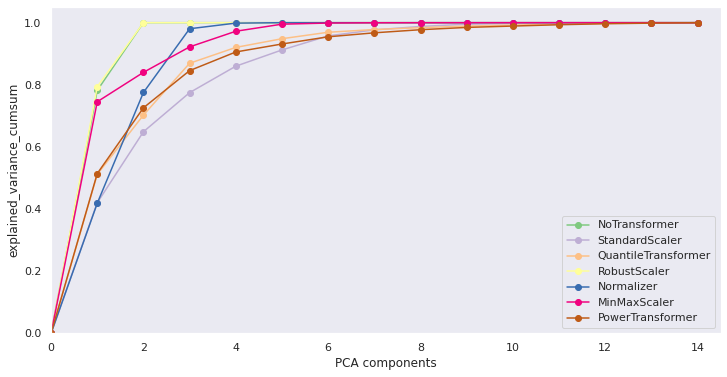

In [41]:
start = time.time()
X_trans_dict, X_pca_dict, instance_pca_dict = transformer_bundle(X, is_get_instance=True)
print('time:', time.time() - start)
X_labeled_PCA = {}
for key,value in X_pca_dict.items():
    X_labeled_PCA[key] = value[idx_labeled,:]
pca_plot_cumsum(instance_pca_dict)

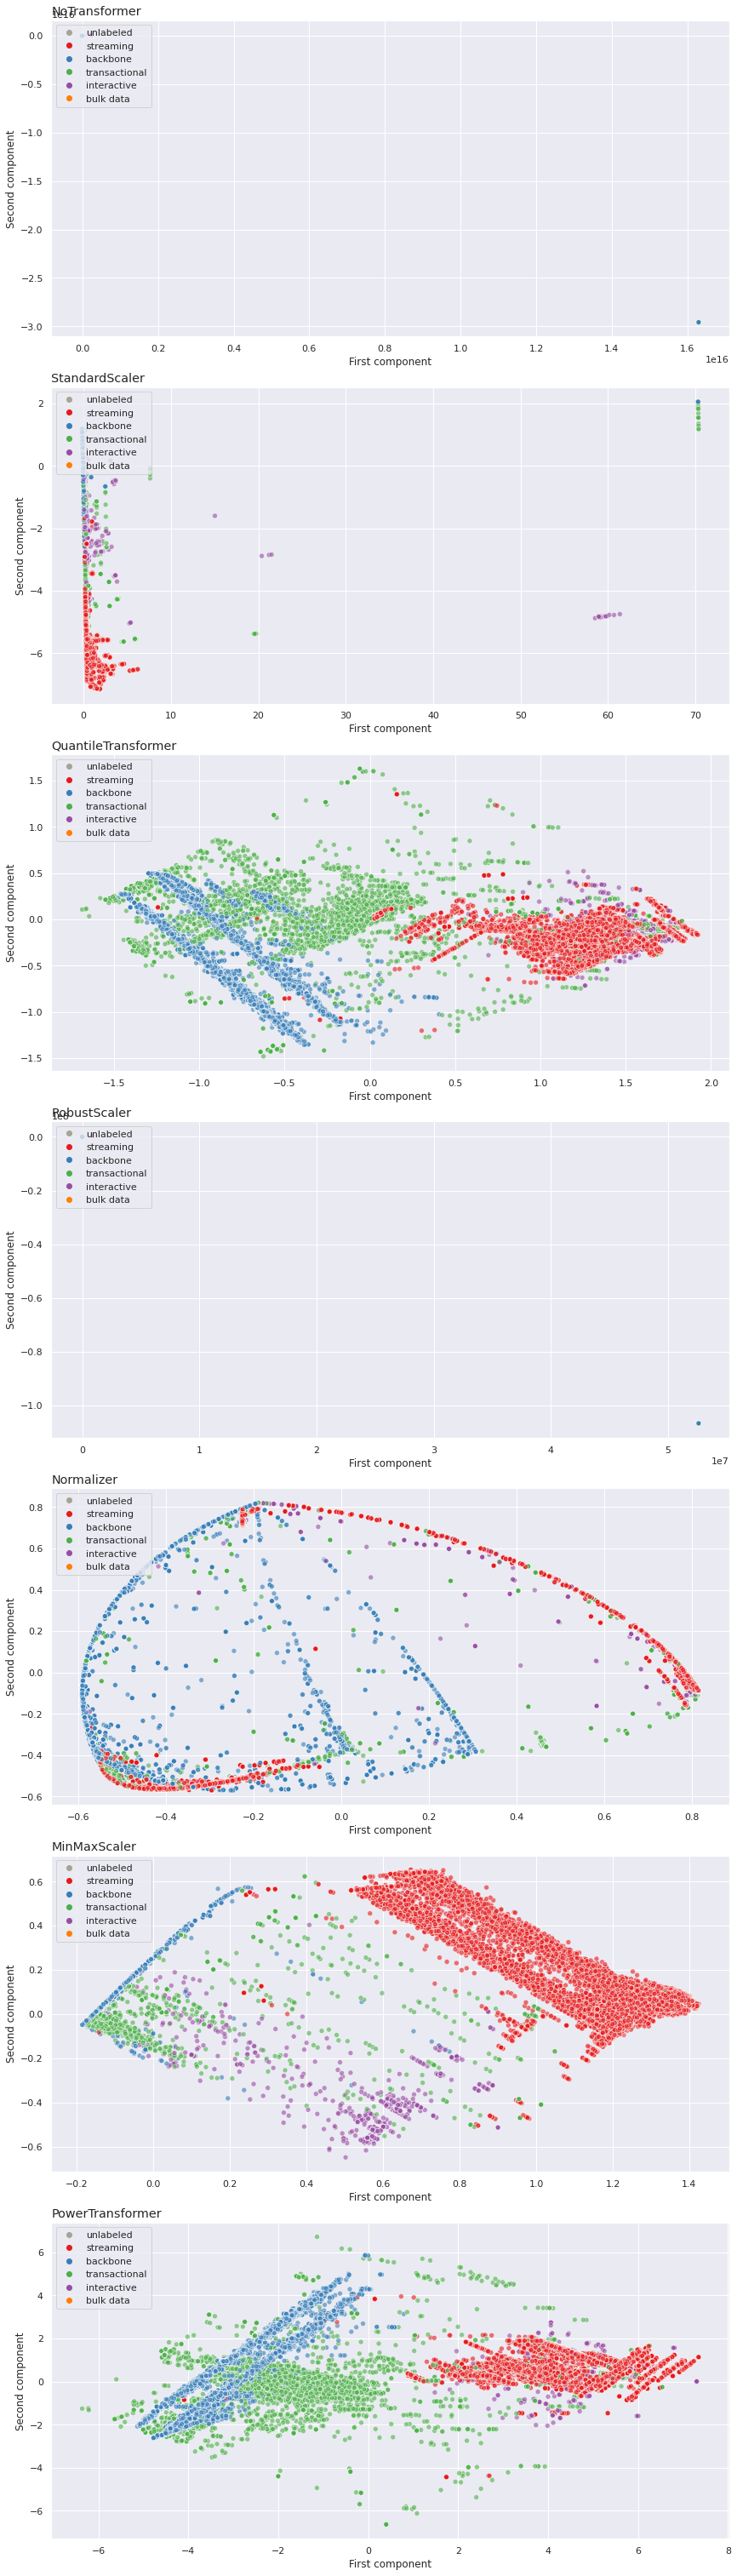

In [42]:
plt.rc('figure', facecolor='w')
pca_scatter_plot(X_labeled_PCA, Y_labeled)

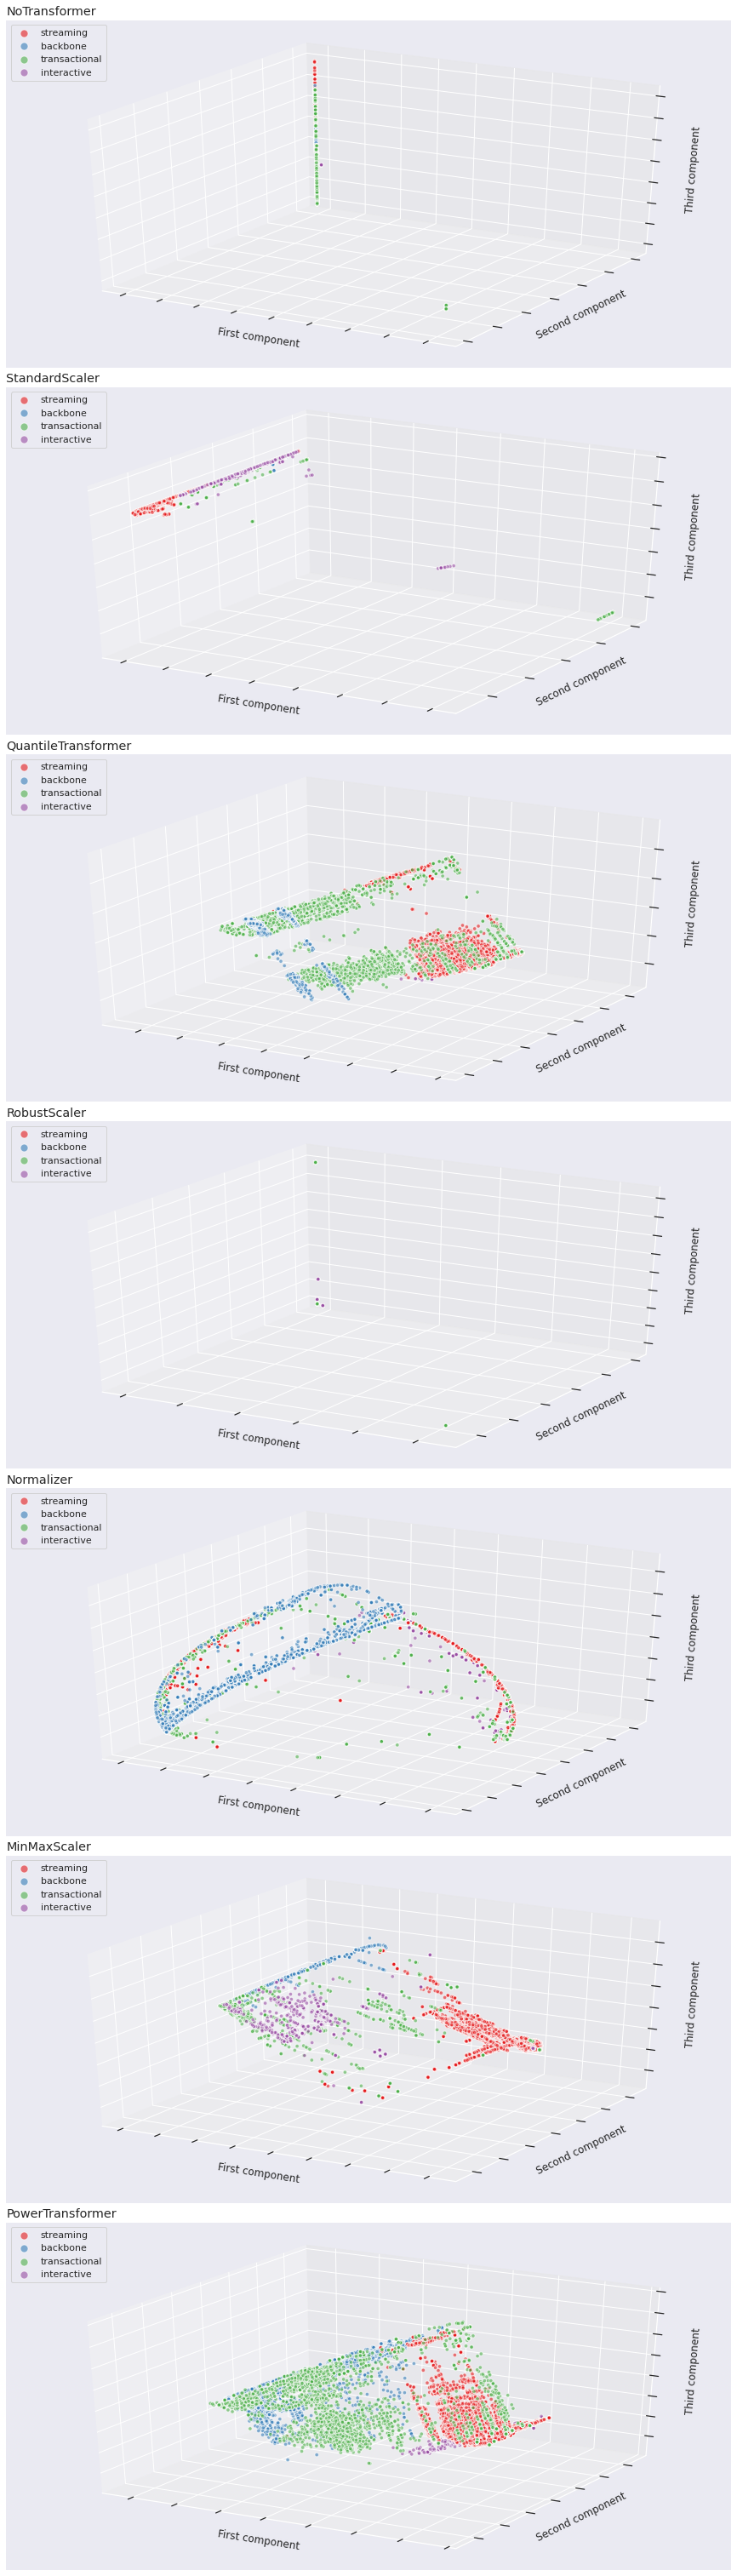

In [43]:
plt.rc('figure', facecolor='w')
pca3d_scatter_plot(X_labeled_PCA, Y_labeled)

In [ ]:
X_test = data.drop(['srcportknown','destportknown','srcport','destport','label'], 1)
start = time.time()
with LocalCluster(processes=True,n_workers=1,threads_per_worker=10) as cluster, Client(cluster) as client, joblib.parallel_backend('dask'):
    X_test_npa = X_test.to_numpy()
    X_test_da = da.from_array(X_test_npa, chunks=X_test_npa.shape).persist()
    wait(X_test_da)

    X_test_trans_dict, X_test_pca_dict, instance_test = transformer_bundle(X_test_da, is_get_instance=True, dask=True)
print('time:', time.time() - start)
X_test_labeled_PCA = {}
for key,value in X_test_pca_dict.items():
    X_test_labeled_PCA[key] = value[idx_labeled,:]

In [ ]:
plt.rc('figure', facecolor='w')
pca_scatter_plot(X_test_labeled_PCA, Y_labeled)

In [ ]:
plt.rc('figure', facecolor='w')
pca_scatter_plot(X_test_labeled_PCA, Y_labeled)

In [ ]:
plt.rc('figure', facecolor='w')
pca3d_scatter_plot(X_test_labeled_PCA, Y_labeled)

In [44]:
inputfile = '/data/maxim/data/traffic/features.txt'
columns = ['label','srcavgbytes','srcvarbytes','srcavgdur','srcvardur','srcavgpackets','srcvapackets',
           'destavgbytes','destvarbytes','destavgdur','destvardur','destavgpackets','destvarpackets']

df2 = pd.read_csv(inputfile, names=columns, nrows = 1000000, skiprows=10000)#1000000)
df2['label'] = df.label



In [45]:
X2=df2.drop('label', 1)
X2['bytes'] = X.bytes
X2['duration'] = X.duration
X2['packets'] = X.packets

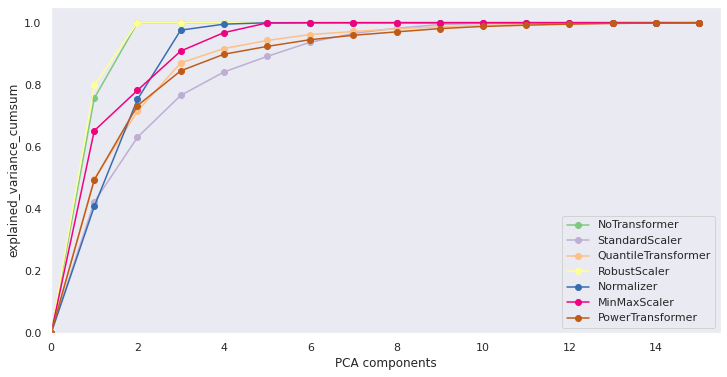

In [46]:
#X_new = X.drop(X.columns.difference(['avgdur','bytes' ,'packets','duration','kurdur', 'skewdur','mindur','minbytes','kurpackets']), 1)
X2_trans_dict, X2_pca_dict,instance_pca_dict2 = transformer_bundle(X2, is_get_instance=True)

X2_labeled_PCA = {}
for key,value in X2_pca_dict.items():
    X2_labeled_PCA[key] = value[idx_labeled,:]
    
pca_plot_cumsum(instance_pca_dict2)

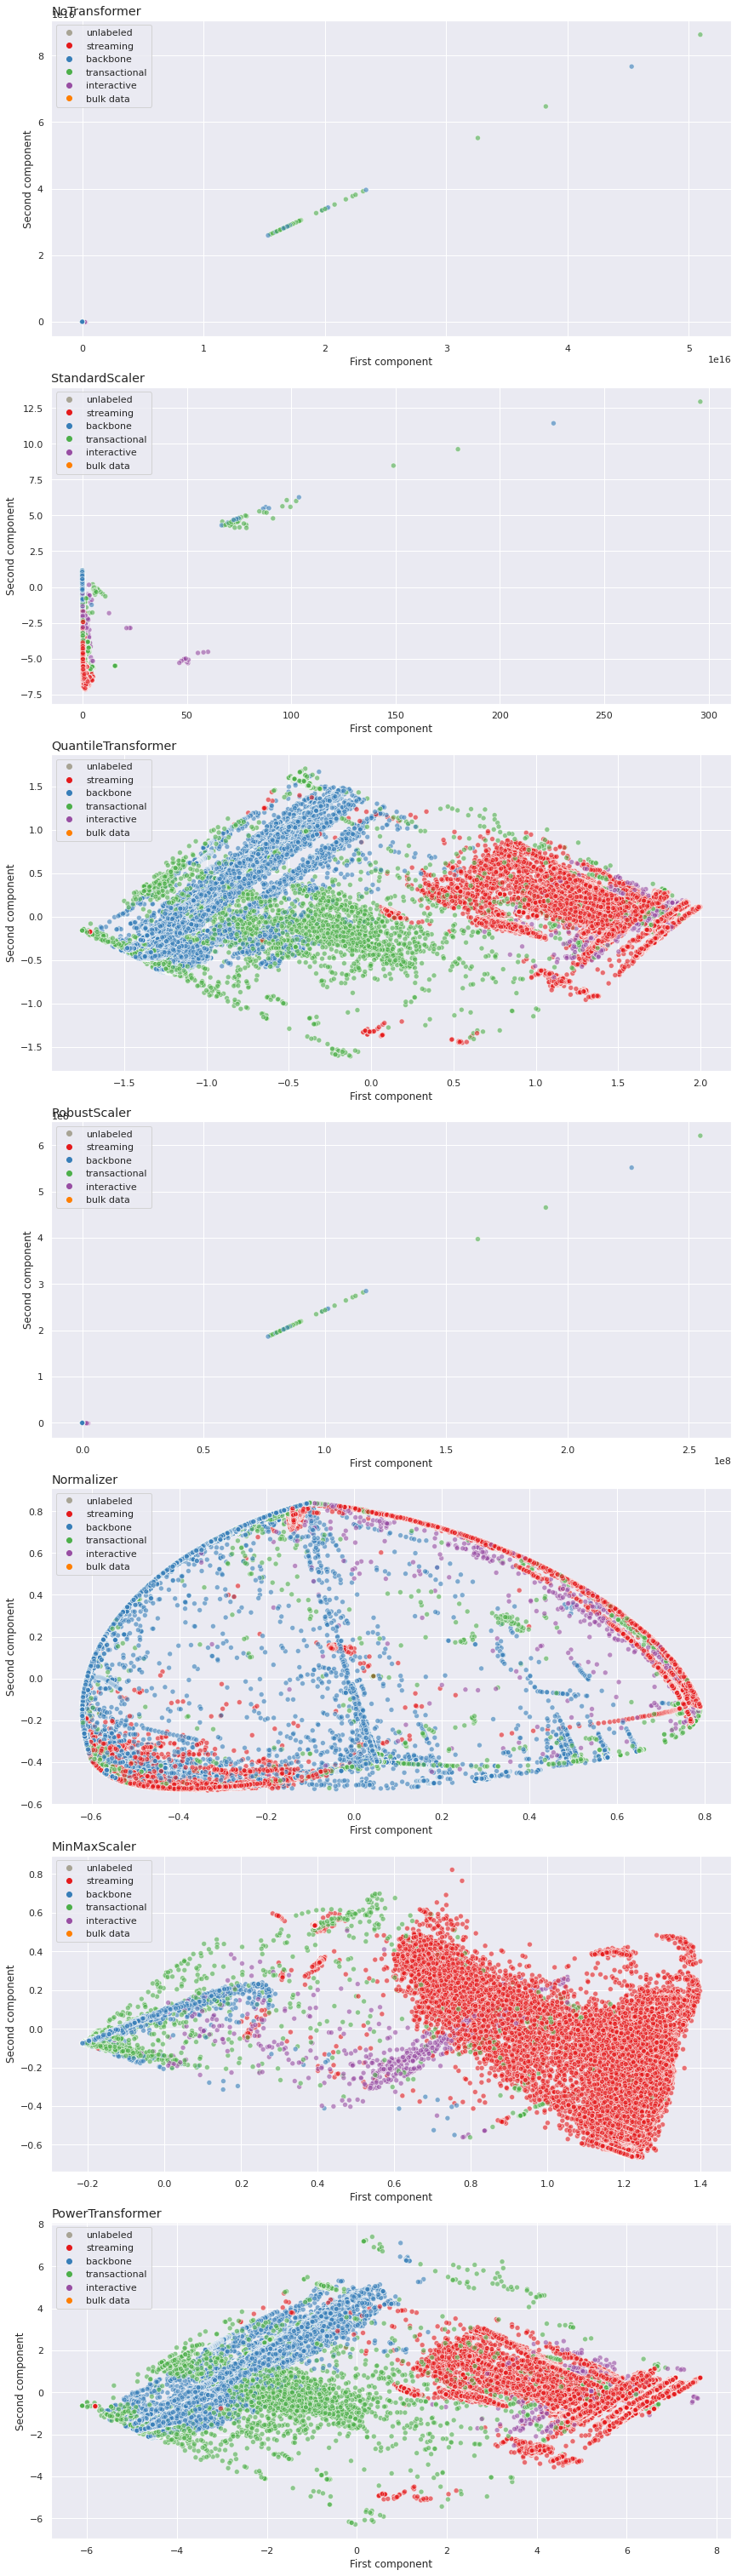

In [47]:
plt.rc('figure', facecolor='w')
pca_scatter_plot(X2_labeled_PCA, Y_labeled)

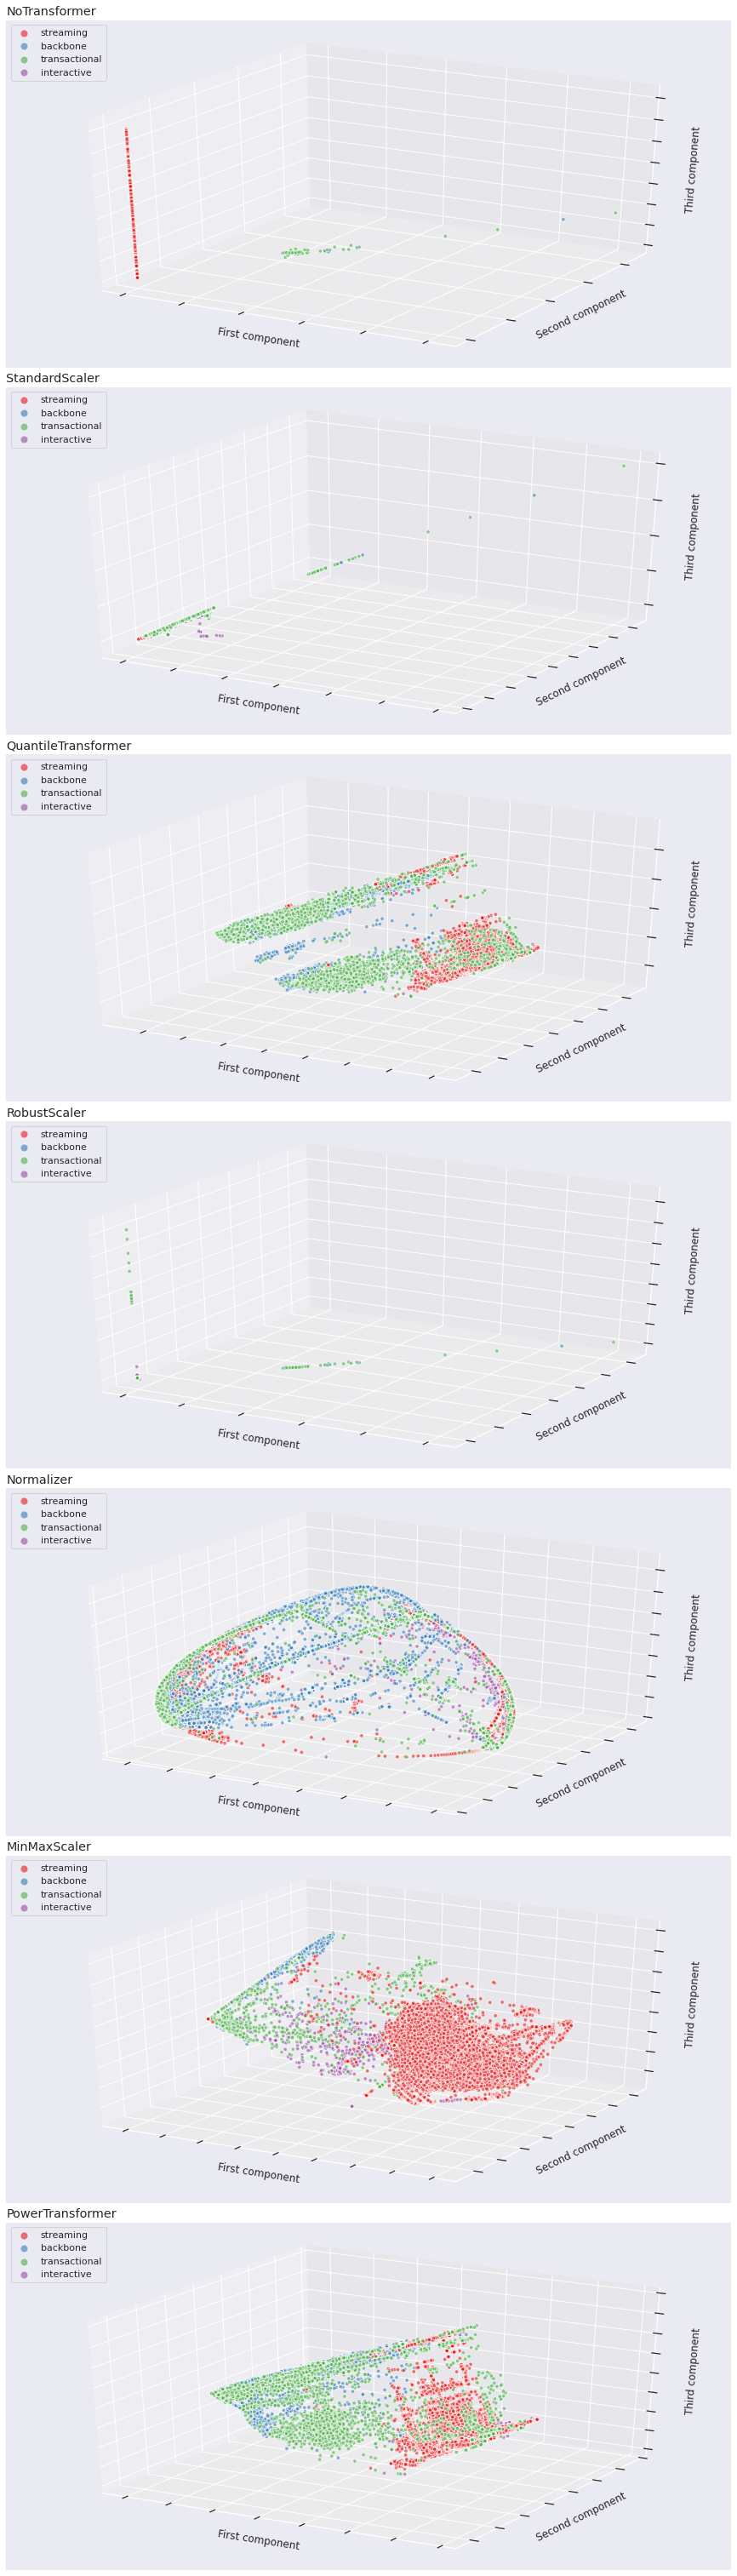

In [48]:
plt.rc('figure', facecolor='w')
pca3d_scatter_plot(X2_labeled_PCA, Y_labeled)

In [22]:
def plot_distortions(x_dict, n, var=None,instance_pca=None):
    fig, axes = plt.subplots(nrows=len(x_dict.keys()), ncols=1, figsize=(9,5*len(x_dict.keys())), sharey='row')
    distortions = []
    for x,key in enumerate(x_dict.keys()):
        d = []
        if var != None:
            varidx = np.argmax(instance_pca[key].explained_variance_ratio_.cumsum() >= var)
            if varidx < 3:
                varidx = 3
        for i in range(1,n):
            kmeans = KMeans(n_clusters=i,random_state=102)
            if var != None:
                kmeans.fit(x_dict[key][:,:varidx]) 
            else:
                kmeans.fit(x_dict[key]) 
            d.append(kmeans.inertia_)
        distortions.append(d)
        this_ax = axes[x]
        this_ax.plot(range(1, n), d, marker='o')

        this_ax.set_xlabel('Number of clusters (k)')
        this_ax.set_ylabel('Distortion')
        this_ax.set_title('MinMaxScaler', y=1, fontsize='large')
        #this_ax.legend(loc=2)
    
    plt.tight_layout(pad=1)
    plt.show()
    #return distortions
            

In [ ]:
'''from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,12))
visualizer.fit(X_test_trans_dict['StandardScaler'])  
visualizer.show()'''

In [ ]:
X_elbow_dict = {}
X_elbow_dict['StandardScaler'] = 5
X_elbow_dict['QuantileTransformer'] = 5
X_elbow_dict['RobustScaler'] = 3
X_elbow_dict['Normalizer'] = 4
X_elbow_dict['MinMaxScaler'] = 4
X_elbow_dict['PowerTransformer'] = 5
X_elbow_dict['NoTransformer'] = 3

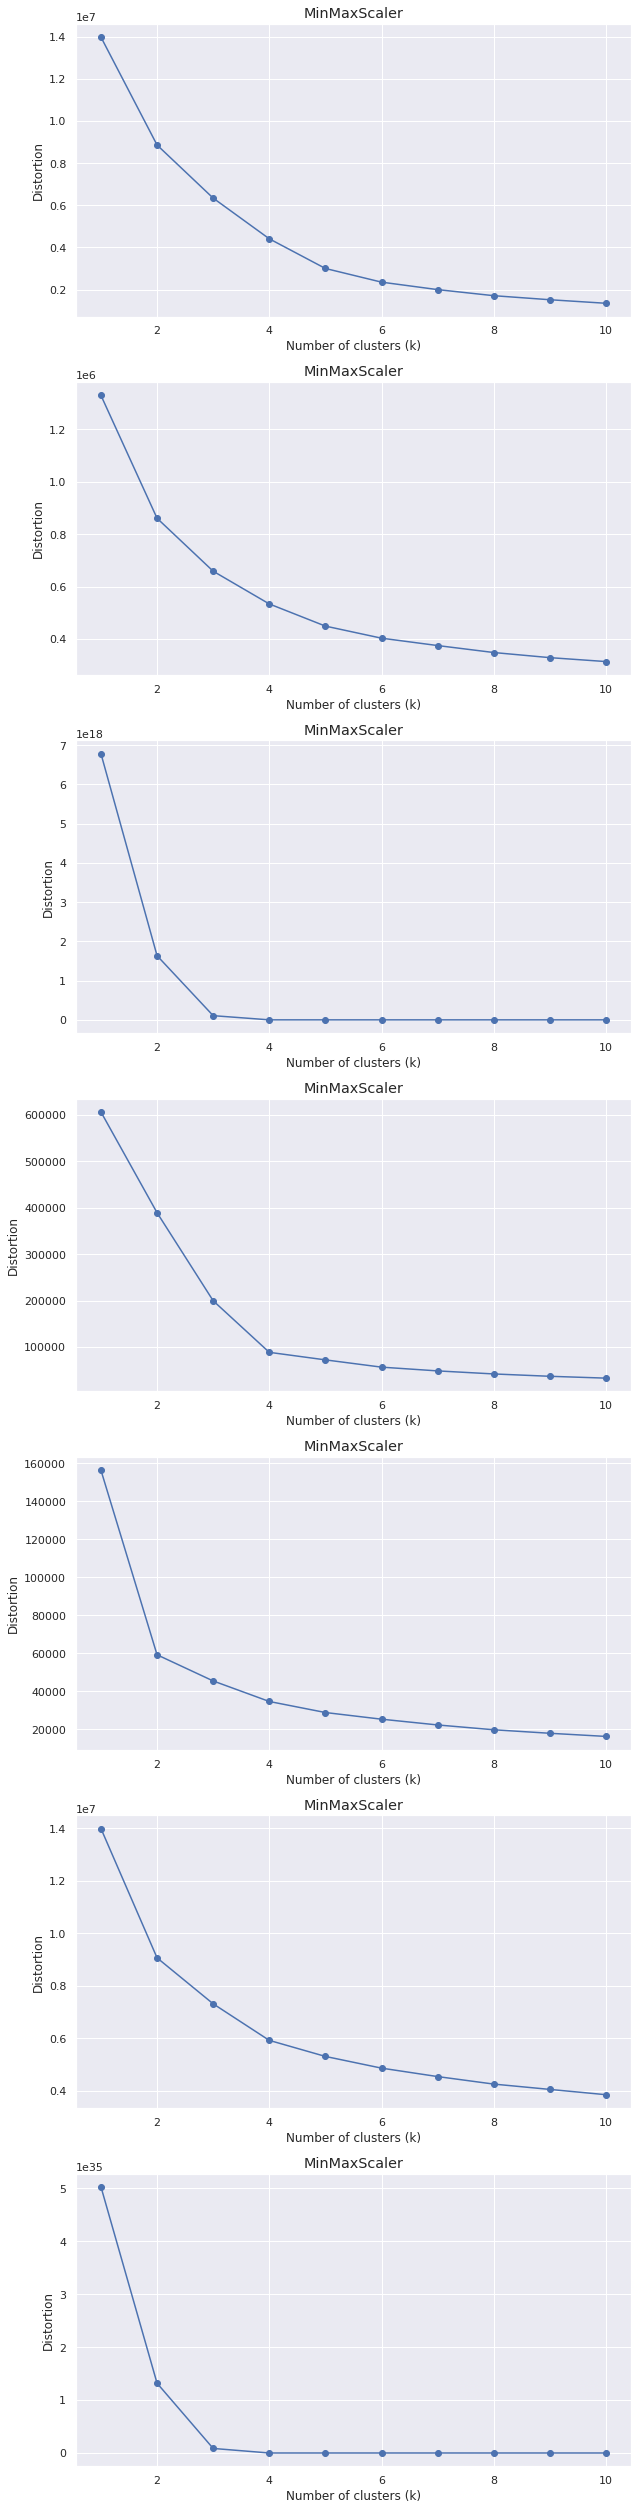

In [23]:
distortions = plot_distortions(X_trans_dict,11)

In [58]:
def build_palette(n, only_labeled):
    if only_labeled:
        if n < 9:
            palette = sns.color_palette('Set1', n)
        elif n < 16:
            palette = sns.color_palette('Set1', 8) +  sns.color_palette('Set2',n-8)
        elif n > 16:
            palette = sns.color_palette('Set1', 8) +  sns.color_palette('Set2',8) + sns.color_palette('Set3',n-16)
        return palette
    else:
        if n<9:
            palette = sns.xkcd_palette(['greyish']) + sns.color_palette('Set1', n-1) 
        elif n < 16:
            palette = sns.xkcd_palette(['greyish']) + sns.color_palette('Set1', 8) +  sns.color_palette('Set2',n-9)
        elif n>16:
            palette = sns.xkcd_palette(['greyish']) + sns.color_palette('Set1', 8) +  sns.color_palette('Set2',8) + sns.color_palette('Set3',n-16)
        return palette
    
'''
if n<9:
            palette = sns.color_palette('Set1', n-1) +  sns.xkcd_palette(['greyish'])
        elif n>9 & n < 16:
            palette = sns.color_palette('Set1', 8) +  sns.color_palette('Set2',n-9) + sns.xkcd_palette(['greyish'])
        elif n>16:
            palette = sns.color_palette('Set1', 8) +  sns.color_palette('Set2',8) + sns.color_palette('Set3',n-16) + sns.xkcd_palette(['greyish'])
        return palette
'''


def build_color_dict(n, labeled):
    p = build_palette(n, labeled)
    colors = {i:j for i,j in enumerate(p)}
    return colors

def calc_counts(labels,unq_y,args):
    #print('args',args)
    #print('arg1',args[0])
    #print('arg2',args[1])
    d_counts = { i:0 for i in range(1,unq_y+1)}
    x = args[0]
    i = args[1]
    for idx in i:
        if labels[idx] != 0:
            d_counts[labels[idx]] += 1
    return d_counts

def parallelize(mydict,n,dataf,unq_y):
    cores = 5
    args = []
    d_counts = [ { i:0 for i in range(1,unq_y+1)} for j in range(n) ]
    func = partial(calc_counts, dataf.label,unq_y)
    for x, value in enumerate(mydict.values()):
        args.append((x,value))
    with Pool(cores) as pool:
        #res = list(tqdm.tqdm(pool.imap(func, args),total=size))
        res = list(pool.imap(func, args))
    for i in range(len(res)):
        d_counts[i] = res[i]
    return d_counts

def restore_idx(idx,old):
    return idx[old]

def build_Kmeans(key,var,y,x_dict,n,instance_pca):
    varidx = np.argmax(instance_pca[key].explained_variance_ratio_.cumsum() > var)
    if varidx < 3:
        varidx = 3
    indices = np.arange(np.shape(y)[0])
    x_train, x_test, y_train, y_test,idx_train, idx_test = train_test_split(x_dict[key][:,:varidx], y, indices, test_size = 0.50, random_state = 42)
    kmeans = KMeans(n_clusters=n,random_state=102)
    kmeans.fit(x_train) 
    y_pred = kmeans.predict(x_test)
    mydict = {i: np.fromiter(map(lambda p: restore_idx(idx_test,p), np.where(y_pred == i)[0]), dtype=np.int) for i in range(n)}
    
    return x_train, x_test, y_train, y_test, idx_train, idx_test, kmeans, y_pred, varidx, mydict

def calc_accuracy(d_counts,n):
    count = 0
    counts = { i:0 for i in range(1,len(d_counts)+1)}
    max_count = { i:0 for i in range(1,len(d_counts)+1)}
    for x,i in enumerate(d_counts):
        print('cluster ',x+1,':',i)
        for key,value in i.items():
            counts[key] += value
            if max_count[key] < value:
                max_count[key] = value
            count+=value
    print('count:', count)
    print('accuracy:')
    for key in counts.keys():
        try:
            print(key,max_count[key]/counts[key])
        except:
            pass
    print('\n')
    return counts, max_count

def label_clusters(d_counts, counts, max_count):
    lab = { i:0 for i in range(0,len(d_counts))}
    max_acc = { i:0 for i in range(0,len(d_counts))}
    for x,i in enumerate(d_counts):
        for key,value in i.items():
            acc = value/counts[key]
            if acc >= max_acc[key] and acc >= max_acc[x]:
                max_acc[key] = acc
                lab[x] = key
        

def pca_scatter_plot_kmeans(x_dict, y, labeled=False, test=False, var=0.9, n=10, plot=True, three_d=False, instance_pca=0, dataf=0):
    kmeans_palette = build_palette(n, labeled)
    kmeans_target_order = list(range(n))
    kmeans_arr = []
    if plot:
        if three_d:
            fig, axes = plt.subplots(subplot_kw=dict(projection='3d'), nrows=len(X_pca_dict.keys()), ncols=1, figsize=(12,6*len(X_pca_dict.keys())), sharey='row')
        else:
            fig, axes = plt.subplots(nrows=len(x_dict.keys()), ncols=1, figsize=(12,6*len(x_dict.keys())), sharey='row')
    for i,key in enumerate(x_dict.keys()):
        if key != "RobustScaler":
            if test:
                x_train, x_test, y_train, y_test,idx_train, idx_test, kmeans, y_pred, varidx, mydict = build_Kmeans(key,var,y,x_dict,n,instance_pca)
                kmeans_arr.append(kmeans)
                if labeled:
                    idx = np.where(y_test != 0)[0]
                    Y = np.take(y_pred,idx)
                    y_test = np.take(y_test,idx)
                    X = x_test[idx,:]
                    print(key, varidx)
                    acc = metrics.accuracy_score(y_test, Y)
                    print("accuracy", acc)
                    unq_y = np.max(np.unique(y))
                    d_counts = parallelize(mydict,n,dataf,unq_y)
                    print("completeness", cs(y_test, Y))
                    print("homogeneity", hs(y_test, Y))
                    if acc > 0.1:
                        counts, max_count = calc_accuracy(d_counts,n)
                    else:
                        counts, max_count = calc_accuracy(d_counts,n) #print('\n')



                else:
                    print(key, varidx, metrics.accuracy_score(y_test, y_pred))
                    X = x_test
                    Y = y_pred
            else:
                X = x_dict[key]
                Y = y
                if labeled:
                    idx = np.where(Y != 0)[0]
                    Y = np.take(Y,idx)
                    X = X[idx,:]
            if plot:
                this_ax = axes[i]
                if three_d:
                    for g in np.sort(np.unique(Y)):
                        idx = np.where(Y == g)[0]
                        this_ax.scatter(np.take(X[:,0],idx), np.take(X[:,1],idx), np.take(X[:,2],idx), '.',
                            alpha=0.6, color=color_dict[g+1], edgecolor='w', label=label_dict[g])

                    # set axis labels and title
                    this_ax.set_xlabel('First component')
                    this_ax.set_ylabel('Second component')
                    this_ax.set_zlabel('Third component')
                    this_ax.w_xaxis.set_ticklabels([])
                    this_ax.w_yaxis.set_ticklabels([])
                    this_ax.w_zaxis.set_ticklabels([])
                    this_ax.set_title(key, loc='left', fontsize='large')
                    this_ax.legend(loc='upper left',markerscale=2)
                else:
                    
                    # plot the first 2 components
                    sns.scatterplot(data=None, x=X[:,0], y=X[:,1], 
                                    hue=Y, hue_order = kmeans_target_order, 
                                    alpha=0.6, palette=kmeans_palette, ax=this_ax)

                    # set axis labels and title
                    this_ax.set_xlabel('First component')
                    this_ax.set_ylabel('Second component')
                    this_ax.set_title(key, loc='left', fontsize='large')
                    this_ax.legend(loc=2)
    if plot:
        plt.tight_layout(pad=0.5)
        plt.show()
    return kmeans_arr

def pca3d_scatter_plot_kmeans(x_dict, y, labeled=False, test=False, var=0.9, n=10,plot=True):
    y = np.array(y)
    c_dict = build_color_dict(n, labeled)
    if plot:
        fig, axes = plt.subplots(subplot_kw=dict(projection='3d'), nrows=len(X_pca_dict.keys()), ncols=1, figsize=(12,6*len(X_pca_dict.keys())), sharey='row')
    
    for i,key in enumerate(X_pca_dict.keys()):
        
        if test:
            varidx = np.argmax(instance_pca_dict[key].explained_variance_ratio_.cumsum() > var)
            if varidx < 3:
                varidx = 3
            x_train, x_test, y_train, y_test = train_test_split(x_dict[key][:,:varidx], y, test_size = 0.50, random_state = 42)
            kmeans = KMeans(n_clusters=n,random_state=102)
            kmeans.fit(x_train) 
            y_pred = kmeans.predict(x_test)
            if labeled:
                idx = np.where(y_test != 0)[0]
                Y = np.take(y_pred,idx)
                y_test = np.take(y_test,idx)
                X = x_test[idx,:]
                print(key, varidx, metrics.accuracy_score(y_test, Y))
            else:
                print(key, varidx, metrics.accuracy_score(y_test, y_pred))
                X = x_test
                Y = y_pred
        else:
            X = x_dict[key]
            Y = y
            if labeled:
                idx = np.where(Y != -1)[0]
                Y = np.take(Y,idx)
                X = X[idx,:]
        if plot:
            this_ax = axes[i]
            # plot the first 3 components
            for g in np.sort(np.unique(Y)):
                idx = np.where(Y == g)[0]
                this_ax.scatter(np.take(X[:,0],idx), np.take(X[:,1],idx), np.take(X[:,2],idx), '.',
                                alpha=0.6, color=c_dict[g], edgecolor='w', label=g)

            # set axis labels and title
            this_ax.set_xlabel('First component')
            this_ax.set_ylabel('Second component')
            this_ax.set_zlabel('Third component')
            this_ax.w_xaxis.set_ticklabels([])
            this_ax.w_yaxis.set_ticklabels([])
            this_ax.w_zaxis.set_ticklabels([])
            this_ax.set_title(key, loc='left', fontsize='large')
            this_ax.legend(loc='upper left',markerscale=2)
    if plot:
        plt.tight_layout(pad=0.5)
        plt.show()

StandardScaler 8
accuracy 0.0009026201774293377
completeness 0.9474147315711706
homogeneity 0.7443737507786887
cluster  1 : {1: 17715, 2: 39, 3: 200, 4: 231}
cluster  2 : {1: 18, 2: 18927, 3: 1528, 4: 90}
cluster  3 : {1: 0, 2: 0, 3: 0, 4: 0}
cluster  4 : {1: 0, 2: 11, 3: 17, 4: 0}
count: 38776
accuracy:
1 0.9989849433260024
2 0.9973652315961427
3 0.8756446991404011
4 0.719626168224299


QuantileTransformer 9
accuracy 0.02615019599752424
completeness 0.625831775981332
homogeneity 0.7497044260845507
cluster  1 : {1: 387, 2: 0, 3: 140, 4: 0}
cluster  2 : {1: 16, 2: 5462, 3: 162, 4: 0}
cluster  3 : {1: 17324, 2: 8, 3: 453, 4: 321}
cluster  4 : {1: 6, 2: 13507, 3: 990, 4: 0}
count: 38776
accuracy:
1 0.976935656685276
2 0.7117563366180113
3 0.5673352435530086
4 1.0


Normalizer 3
accuracy 0.3030482772849185
completeness 0.14140694064900292
homogeneity 0.21509986379739943
cluster  1 : {1: 7871, 2: 0, 3: 268, 4: 145}
cluster  2 : {1: 2429, 2: 4235, 3: 400, 4: 174}
cluster  3 : {1: 5135, 2: 87

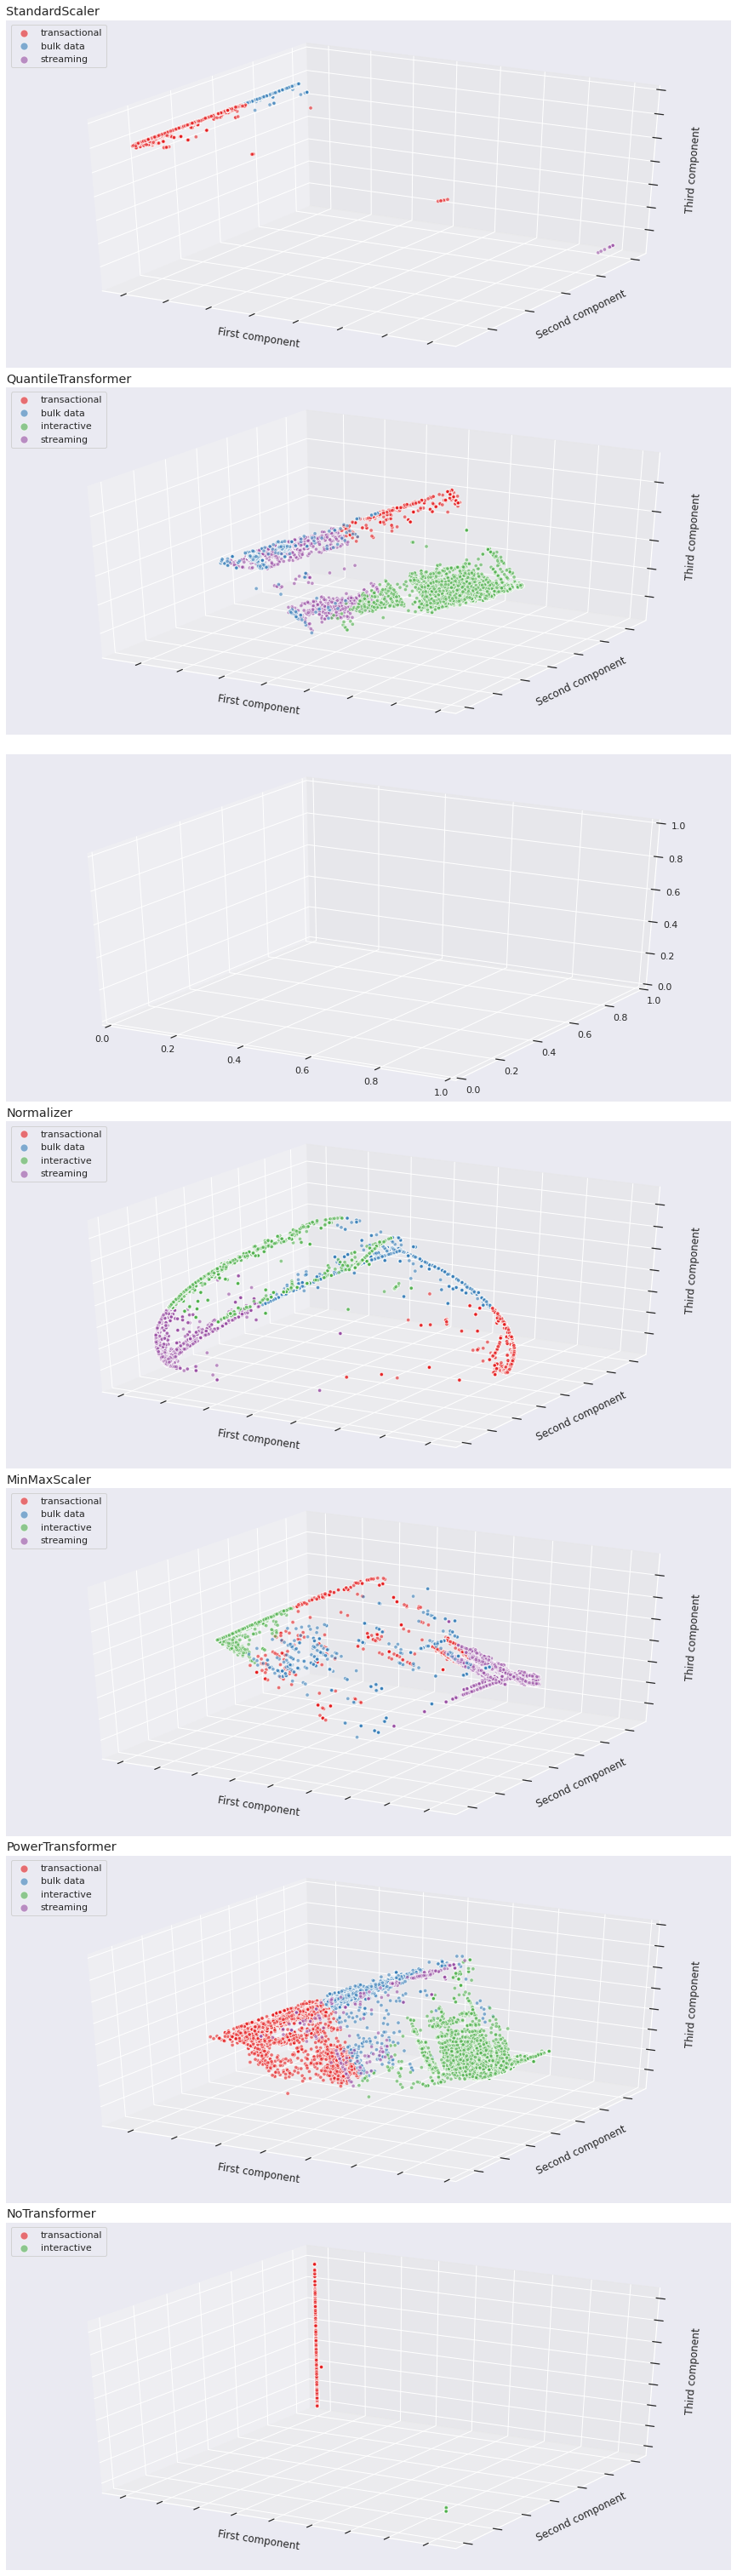

In [61]:
labels = ['transactional', 'bulk data','interactive','streaming']
label_dict = {i:j for i,j in enumerate(labels)}
# Only labeled data plotted
plt.rc('figure', facecolor='w')
kmeans_arr = pca_scatter_plot_kmeans(X_pca_dict, Y, True, True,0.99,4, True,True,instance_pca_dict,df)

StandardScaler 8
accuracy 0.4566742314833918
completeness 0.9462285644011318
homogeneity 0.7433042309882942
cluster  1 : {1: 42, 2: 18939, 3: 1544, 4: 78}
cluster  2 : {1: 17691, 2: 27, 3: 184, 4: 243}
cluster  3 : {1: 0, 2: 0, 3: 0, 4: 0}
cluster  4 : {1: 0, 2: 11, 3: 17, 4: 0}
count: 38776
accuracy:
1 0.9976315344273389
2 0.9979975760130685
3 0.8848137535816619
4 0.7570093457943925


QuantileTransformer 9
accuracy 0.003713637301423561
completeness 0.6305700938522756
homogeneity 0.7461923213921481
cluster  1 : {1: 36, 2: 5037, 3: 147, 4: 0}
cluster  2 : {1: 6, 2: 13929, 3: 1042, 4: 0}
cluster  3 : {1: 17317, 2: 11, 3: 429, 4: 321}
cluster  4 : {1: 374, 2: 0, 3: 127, 4: 0}
count: 38776
accuracy:
1 0.9765409124231659
2 0.733993781946567
3 0.597134670487106
4 1.0


Normalizer 3
accuracy 0.325613781720652
completeness 0.10979402355866494
homogeneity 0.16877098293456302
cluster  1 : {1: 3429, 2: 8814, 3: 382, 4: 7}
cluster  2 : {1: 7993, 2: 544, 3: 332, 4: 153}
cluster  3 : {1: 2319, 2: 40

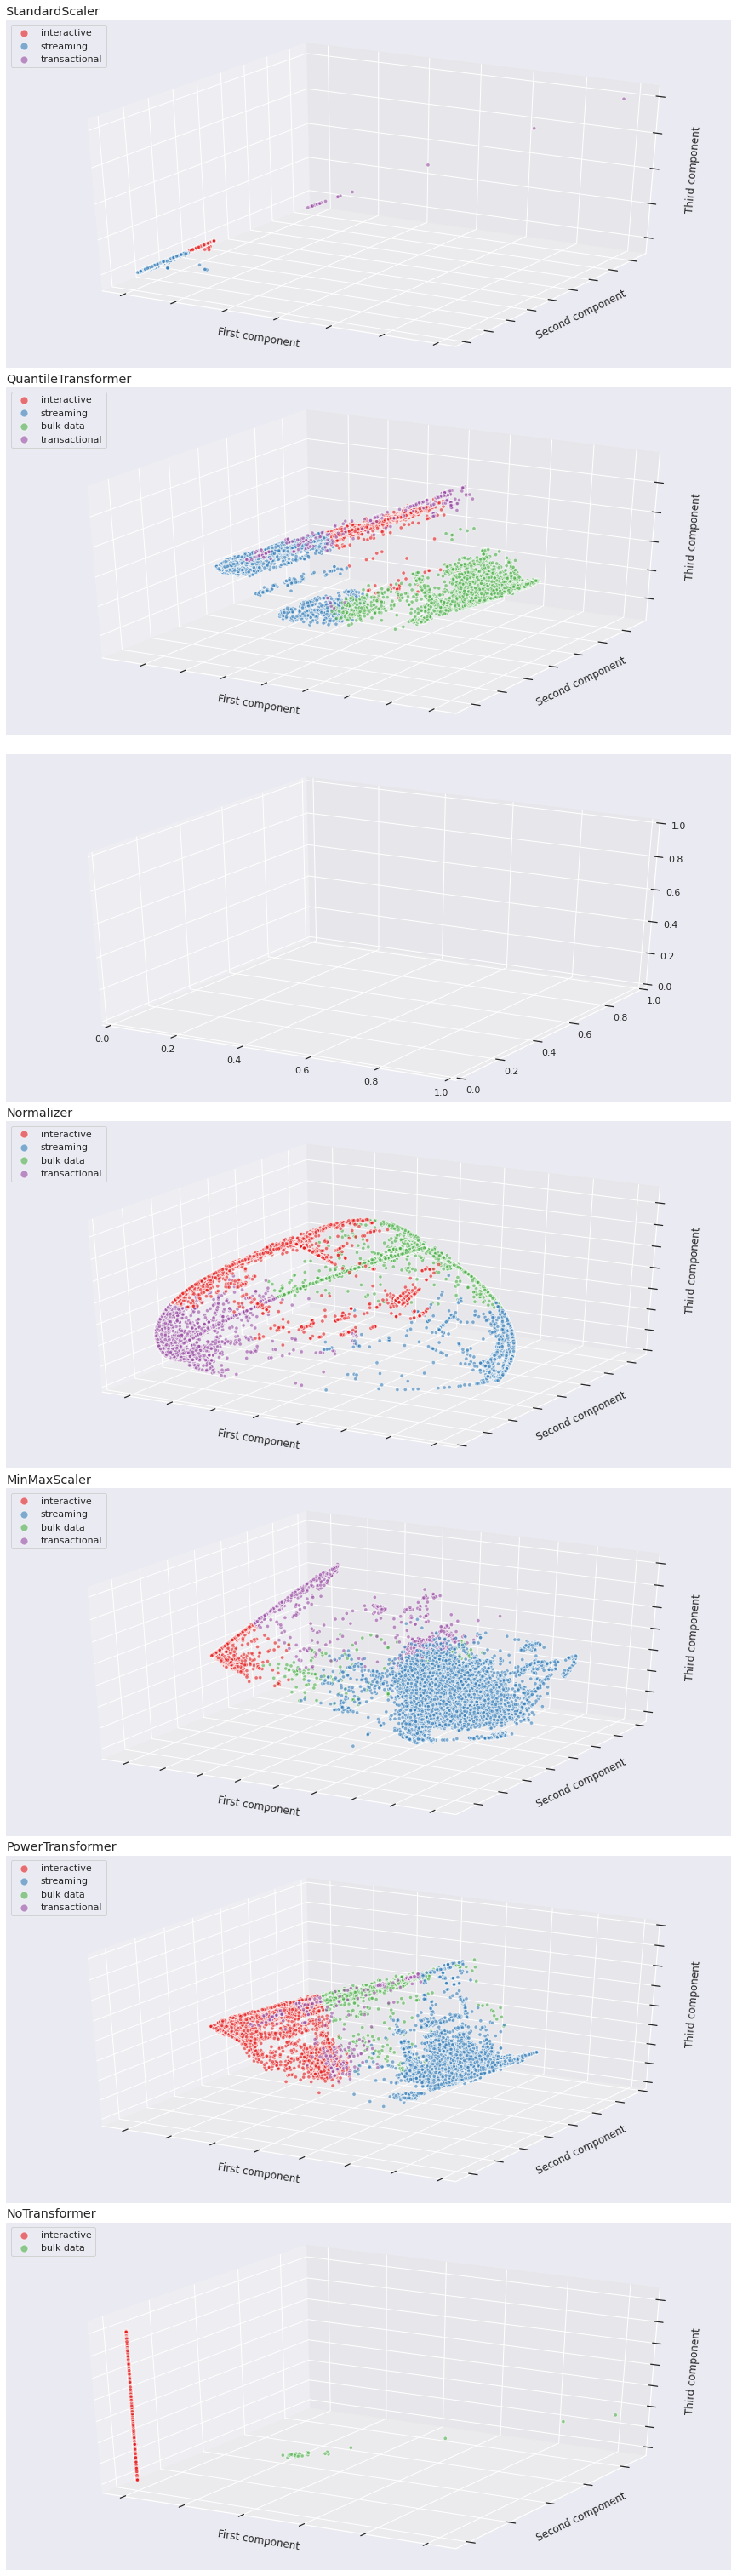

In [64]:
labels = ['interactive','streaming','bulk data','transactional']
label_dict = {i:j for i,j in enumerate(labels)}
# Only labeled data plotted
plt.rc('figure', facecolor='w')
kmeans_arr = pca_scatter_plot_kmeans(X2_pca_dict, Y, True, True,0.99,4, True,True,instance_pca_dict2,df)

In [ ]:
# Only labeled data plotted
plt.rc('figure', facecolor='w')
pca_scatter_plot_kmeans(X2_pca_dict, Y, True, True,0.99,10, False,instance_pca_dict2,df2)

In [ ]:
plt.rc('figure', facecolor='w')
pca_scatter_plot_kmeans(X_test_pca_dict, Y, True, True,0.99,10, False,instance_test,df)

In [ ]:
plt.rc('figure', facecolor='w')
pca_scatter_plot_kmeans(X_test_pca_dict, Y, True, True,0.99,10, False,instance_test,df)

In [ ]:
instance_test

In [ ]:
indices = np.arange(np.shape(Y)[0])
x_train, x_test, y_train, y_test,idx_train, idx_test = train_test_split(X_pca_dict['StandardScaler'][:,:5], Y, indices, test_size = 0.50, random_state = 42)
kmeans = KMeans(n_clusters=5,random_state=102)
kmeans.fit(x_train) 
y_pred = kmeans.predict(x_test)
y_test -= 1
mydict = {i: np.fromiter(map(lambda p: restore_idx(idx_test,p), np.where(y_test == i)[0]), dtype=np.int) for i in range(5)}


idx = np.where(y_test != -1)[0]
y_pred = np.take(y_pred,idx)
y_test = np.take(y_test,idx)
X = x_test[idx,:]



np.where(y_pred == 0)
np.where(y_test == 3)


In [ ]:
kmeans.cluster_centers_

In [ ]:
idx_test

In [ ]:
np.where(y_test == 3)[0]

In [ ]:
mydict[0]

In [ ]:
df.iloc[192203]['label']

In [ ]:
df.loc[df.label != -1]

In [ ]:


#d = [ { 'StandardScaler':0, 'QuantileTransformer':0, 'RobustScaler':0, 'Normalizer':0, 'MaxAbsScaler':0, 'MinMaxScaler':0, 'PowerTransformer':0, 'NoTransformer':0} for i in range(5) ]
d = { 'StandardScaler':0, 'QuantileTransformer':0, 'RobustScaler':0, 'Normalizer':0, 'MaxAbsScaler':0, 'MinMaxScaler':0, 'PowerTransformer':0, 'NoTransformer':0}
'''for i in range(10,15):
    print(i)
    for j in range(20):
        #print(i)'''

for key in X_pca_dict:
    train_size = int(np.shape(X_pca_dict[key])[0]/(4/3))
    x_train = X_pca_dict[key][:train_size,:12]
    x_test = X_pca_dict[key][train_size:,:12]
    y_test = Y[train_size:]
    kmeans = KMeans(n_clusters=4, random_state = 2020)
    kmeans.fit(x_train) 
    y_pred = kmeans.predict(x_test)
    #print(key)
    #print(metrics.accuracy_score(y_test, y_pred))
    d[key] = metrics.accuracy_score(y_test, y_pred)

for key in d:
    print(key, d[key])


In [ ]:
test_size = int(np.shape(X_pca_dict['PowerTransformer'])[0]/4)
train_size = int(np.shape(X_pca_dict['PowerTransformer'])[0]/(4/3))
x_train = X_pca_dict['PowerTransformer'][:train_size,:12]
x_test = X_pca_dict['PowerTransformer'][train_size:,:12]
y_test = Y[train_size:]
kmeans = KMeans(n_clusters=4)
kmeans.fit(x_train) 
y_pred = kmeans.predict(x_test)
print(metrics.accuracy_score(y_test, y_pred))
#d[i-10][key] += (metrics.accuracy_score(y_test, y_pred)-d[i-10][key])/(j+1)

In [ ]:
#Coordinates of cluster centers with shape [n_clusters, n_features]
kmeans.cluster_centers_

#Labels of each point
kmeans.labels_

# !! Get the indices of the points for each corresponding cluster
mydict = {i: np.where(kmeans.labels_ == i)[0] for i in range(kmeans.n_clusters)}

# Transform the dictionary into list
dictlist = []
for key, value in mydict.items():
    temp = [key,value]
    dictlist.append(temp)

In [ ]:
d_counts = [ { 1:0, 2:0, 3:0, 4:0, 5:0, 6:0} for i in range(6) ]
for x,l in enumerate(dictlist):
    for i in l[1]:
        d_counts[x][data.iloc[i]['label']] +=1


In [ ]:
clusters = ['']
for i in d_counts:
    print(i)

In [ ]:
pd.options.display.max_rows = 50
pd.options.display.min_rows = pd.options.display.max_rows
idx = data.iloc[dictlist[][1]].index
flows = df.loc[idx]
flows.loc[(flows['label'] == 2)]['srcport'].value_counts()


In [ ]:
for i in range(5):
    print('cluster', i)
    idx = data.iloc[dictlist[i][1]].index
    
    print(data.loc[idx][:].mean())


In [ ]:
cameras = data.loc[df['label'] == 1]
sns.set(rc={'figure.figsize':(12,8)})
ax1 = sns.kdeplot(cameras['bytes'], bw = 0.001, shade=True, label = 'log(bytes)');
sns.kdeplot(cameras['maxbytes'], shade=True, label = 'maxbytes');
sns.kdeplot(cameras['minbytes'], shade=True, label = 'minbytes');
sns.kdeplot(cameras['avgbytes'], shade=True, label = 'avgbytes');
sns.kdeplot(cameras['varbytes'], shade=True, label = 'varbytes');
sns.kdeplot(cameras['skewbytes'], shade=True, label = 'skewbytes');
sns.kdeplot(cameras['kurbytes'], shade=True, label = 'kurbytes');

ax1.set(xlabel='quantity')

In [ ]:
sns.set(rc={'figure.figsize':(12,8)})
ax2 = sns.kdeplot(cameras['packets'], bw = 0.001, shade=True, label = 'log(packets)');
sns.kdeplot(cameras['maxpackets'], shade=True, label = 'max');
sns.kdeplot(cameras['minpackets'], shade=True, label = 'min');
sns.kdeplot(cameras['avgpackets'], shade=True, label = 'avg');
sns.kdeplot(cameras['varpackets'], shade=True, label = 'var');
sns.kdeplot(cameras['skewpackets'], shade=True, label = 'skew');
sns.kdeplot(cameras['kurpackets'], shade=True, label = 'kur');

ax2.set(xlabel='quantity')

In [ ]:
sns.set(rc={'figure.figsize':(12,8)})
ax3 = sns.kdeplot(cameras['duration']/3500, bw = 0.001, shade=True, label = '(duration)');
sns.kdeplot(cameras['maxdur']/3500, shade=True, label = 'max');
sns.kdeplot(cameras['mindur']/3500, shade=True, label = 'min');
sns.kdeplot(cameras['avgdur']/3500, shade=True, label = 'avg');
#sns.kdeplot(cameras['vardur'], shade=True, label = 'var');
sns.kdeplot(cameras['skewdur'], shade=True, label = 'skew');
sns.kdeplot(cameras['kurdur'], shade=True, label = 'kur');

ax3.set(xlabel='quantity')

In [ ]:
printers = data.loc[df['label'] == 7]
sns.set(rc={'figure.figsize':(12,8)})
ax1 = sns.kdeplot(printers['bytes'], bw = 0.001, shade=True, label = 'log(bytes)');
sns.kdeplot(printers['maxbytes'], shade=True, label = 'maxbytes');
sns.kdeplot(printers['minbytes'], shade=True, label = 'minbytes');
sns.kdeplot(printers['avgbytes'], shade=True, label = 'avgbytes');
sns.kdeplot(printers['varbytes'], shade=True, label = 'varbytes');
sns.kdeplot(printers['skewbytes'], shade=True, label = 'skewbytes');
sns.kdeplot(printers['kurbytes'], shade=True, label = 'kurbytes');

ax1.set(xlabel='quantity')

In [ ]:
# alexa port = 33434
# printer port = 9100
port = 33434
pd.options.display.min_rows=100
pd.options.display.max_rows = pd.options.display.min_rows
printers = data.loc[(df['srcport'] == port)]
print(printers.shape)
ax1 = sns.kdeplot(printers['bytes'], bw = 0.001, shade=True, label = 'log(bytes)');
sns.kdeplot(printers['maxbytes'], shade=True, label = 'maxbytes');
sns.kdeplot(printers['minbytes'], shade=True, label = 'minbytes');
sns.kdeplot(printers['avgbytes'], shade=True, label = 'avgbytes');
sns.kdeplot(printers['varbytes'], shade=True, label = 'varbytes');
sns.kdeplot(printers['skewbytes'], shade=True, label = 'skewbytes');
sns.kdeplot(printers['kurbytes'], shade=True, label = 'kurbytes');

ax1.set(xlabel='quantity')
#socket.gethostbyaddr('52.46.128.105')


In [ ]:
def hostbyaddr(x):
    x = str(x)
    try:
        a = socket.gethostbyaddr(x)
    except :
        a = x
    return a

In [ ]:
labeled = df.loc[df.label != 0]

In [ ]:
data.loc[(df['destport'] == 33434)]


In [ ]:
X=data.loc[data['label'] != 0]
Y=X.label
X = X.drop('label',axis=1)

bestfeatures = SelectKBest(score_func=f_classif, k=10)
fit = bestfeatures.fit(X,Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(10,'Score'))



In [ ]:
X_test=data
Y_test=df.label
X_test = X_test.drop('label', 1)
idx_test = np.where((Y_test != 0))[0]
Y_test_labeled = np.take(Y_test,idx_test)
X_test_labeled = X_test.iloc[idx_test,:]

model = ExtraTreesClassifier()
model.fit(X_test_labeled,Y_test_labeled)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X_test_labeled.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

In [ ]:
X_test_labeled = X_test.iloc[idx_test,:]
X_test_labeled = X_test_labeled.drop(X_test_labeled.columns.difference(list(feat_importances.nlargest(12)._index)), 1)
X_test_trans_dict, X_test_pca_dict = transformer_bundle(X_test_labeled, is_get_instance=False)
plt.rc('figure', facecolor='w')
pca_scatter_plot(X_test_pca_dict, Y_test_labeled)

In [ ]:
pca3d_scatter_plot(X_test_pca_dict, Y_test_labeled)

In [ ]:
feature_list = list(X.columns)
train_features, test_features, train_labels, test_labels = train_test_split(X, Y, test_size = 0.95, random_state = 42)


In [ ]:
rf = RandomForestRegressor(n_estimators = 100, random_state = 42)
rf.fit(train_features, train_labels)
predictions = rf.predict(test_features)
predictions = [int(item) for item in predictions]
metrics.accuracy_score(predictions, test_labels)

In [ ]:
list(feat_importances.nlargest(10)._index)